<a href="https://colab.research.google.com/github/Pallavi707/MSc-AI-Coursework/blob/pymlrf_package_CW2/CW2_Questions_105_marks_QUESTIONS_MFLZ6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data.

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [ ]:
COLLAB = True
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/Pallavi707/pymlrf_1.git #including my github with hange made in packages
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/Pallavi707/comp0188_cw2_public.git #including my github with hange made in packages
    !pip install typeguard==2.13.3

Mounted at /content/drive
  Cloning https://github.com/Pallavi707/pymlrf_1.git to /tmp/pip-req-build-wewhysi3
  Running command git clone --filter=blob:none --quiet https://github.com/Pallavi707/pymlrf_1.git /tmp/pip-req-build-wewhysi3
  Resolved https://github.com/Pallavi707/pymlrf_1.git to commit febfe5d073fb6c823a1b4178c83a3e7f85c253e6
  Preparing metadata (setup.py) ... done
  Created wheel for pymlrf: filename=pymlrf-1.0.0-py3-none-any.whl size=20698 sha256=b4d2bc62fa06bb611cbc1cfe49a3d7392426d9cde97f8276958d2a3870f23247
  Stored in directory: /tmp/pip-ephem-wheel-cache-bfrv71jl/wheels/e1/bb/7b/f2fc31090104d1660dd12c71b272510cba9c19f8053012f62f
Successfully built pymlrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.6 MB/s eta 0:00:00
  Cloning https://github.com/Pallavi707/comp0188_cw2_public.git to /tmp/pip-req-build-t7kq927b
  Running command git clone --filter=blob:none --quiet https://github.com/Pallavi707/comp0188_cw2_public.git /tmp/pip-req-build-t7kq927b
  Reso

Ignore the error:
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [ ]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = False
print(project_options.debug)

True
False


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch.optim as optim
from torchvision.models import vgg16
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import datetime



2024-12-16 00:58:07,189 - pymlrf - WARNING - pymlrf environment variable not set. Using default path for logging. (__init__.py:44)
2024-12-16 00:58:07,196 - pymlrf - DEBUG - Logging file successfully identified (__init__.py:59)
DEBUG:pymlrf:Logging file successfully identified


In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor = torch.randn(3, 3).to(device)
print(tensor)


tensor([[-0.3877, -0.0320,  2.4476],
        [ 0.0687,  0.1824, -0.0669],
        [ 1.0349,  0.7892, -0.1006]], device='cuda:0')


In [ ]:
print(train_dh.loc)

/content/drive/MyDrive/comp0188_2425/cw2/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [ ]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = True
if RUN_PREPROCESSING:
  main()

(35722, 5)
Transitions excluded: 0.5418200474571924
25469
2901
7352
453
51
126


/usr/local/lib/python3.10/dist-packages/comp0188_cw2/Preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_test"] = np.where(
/usr/local/lib/python3.10/dist-packages/comp0188_cw2/Preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tran_df_sub["is_val"] = np.where(
/usr/local/lib/python3.10/dist-packages/comp0188_cw2/Preprocessing.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [ ]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


# EDA

In [ ]:
# Checking the shape of the data loaded for front_cam_ob and mount_cam_ob
print("Front Cam Observation Shape:", train_nps["front_cam_ob"].shape)
print("Mount Cam Observation Shape:", train_nps["mount_cam_ob"].shape)



Front Cam Observation Shape: (25469, 224, 224)
Mount Cam Observation Shape: (25469, 224, 224)


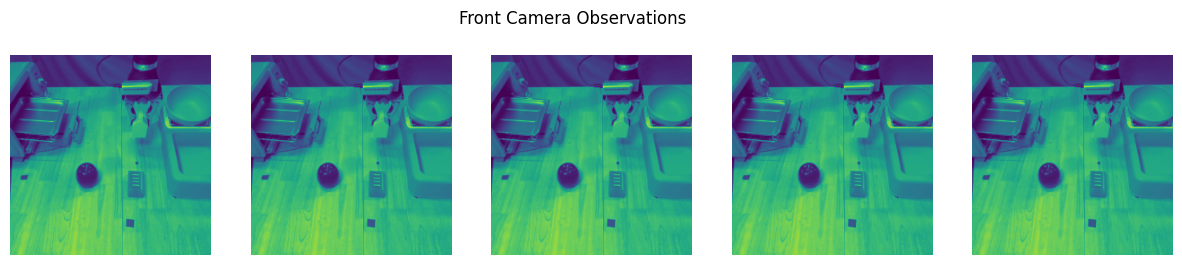

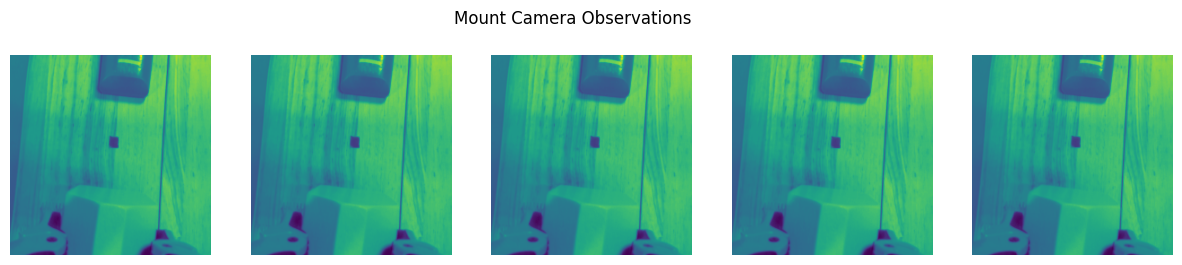

In [ ]:
# Visualize image observations to check image clarity
def plot_images(images, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Visualize front camera observations
front_cam_images = train_nps["front_cam_ob"]
plot_images(front_cam_images, "Front Camera Observations")

# Visualize mount camera observations
mount_cam_images = train_nps['mount_cam_ob']
plot_images(mount_cam_images, "Mount Camera Observations")

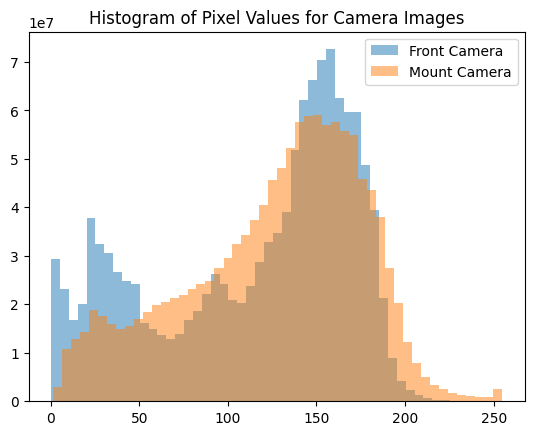

In [ ]:
# Image Intensity observation using histograms of pixel values
plt.hist(front_cam_images.flatten(), bins=50, alpha=0.5, label="Front Camera")
plt.hist(mount_cam_images.flatten(), bins=50, alpha=0.5, label="Mount Camera")
plt.legend(loc='upper right')
plt.title("Histogram of Pixel Values for Camera Images")
plt.show()


In [ ]:
# Analyzing the shape of the images (checking if unique shapes are present)
print("Front Camera Image Shapes:", set([img.shape for img in train_nps["front_cam_ob"]]))
print("Mount Camera Image Shapes:", set([img.shape for img in train_nps["mount_cam_ob"]]))


Front Camera Image Shapes: {(224, 224)}
Mount Camera Image Shapes: {(224, 224)}


In [ ]:
# Analysing missing values in the dataset
for key, value in train_nps.items():
    if isinstance(value, np.ndarray):
        missing = np.isnan(value).sum()
        print(f"Key: {key} - Missing Values: {missing}")
    else:
        print(f"Key: {key} - Not an array")


Key: actions - Missing Values: 0
Key: front_cam_ob - Missing Values: 0
Key: mount_cam_ob - Missing Values: 0
Key: terminals - Missing Values: 0
Key: ee_cartesian_pos_ob - Missing Values: 0
Key: ee_cartesian_vel_ob - Missing Values: 0
Key: joint_pos_ob - Missing Values: 0


In [ ]:
# Computing statictics of the dataset

def dataset_statistics(dataset, dataset_name):

    print(f"\n{'-' * 30}\nStatistics for {dataset_name} dataset\n{'-' * 30}")

    for key, values in dataset.items():
        values = np.array(values, dtype=np.float32)
        cleaned_values = values[np.isfinite(values)]

        if cleaned_values.size == 0:
            print(f"{key}: No valid data points (all values invalid).")
            continue

        # Computing statistics
        mean = np.mean(cleaned_values)
        mode = pd.Series(cleaned_values).mode().iloc[0] if len(cleaned_values) > 0 else "N/A"
        std = np.std(cleaned_values)
        print(f"{key}:")
        print(f"  Mean: {mean:.4f}")
        print(f"  Mode: {mode:.4f}")
        print(f"  Std: {std:.4f}")


dataset_statistics(train_nps, "Train")



------------------------------
Statistics for Train dataset
------------------------------
actions:
  Mean: 0.2495
  Mode: 0.0000
  Std: 0.5127
front_cam_ob:
  Mean: 114.9143
  Mode: 140.6250
  Std: 55.8003
mount_cam_ob:
  Mean: 126.0332
  Mode: 141.3750
  Std: 50.2551
terminals:
  Mean: 0.0178
  Mode: 0.0000
  Std: 0.1322
ee_cartesian_pos_ob:
  Mean: 0.1237
  Mode: 0.9907
  Std: 0.4107
ee_cartesian_vel_ob:
  Mean: -0.0031
  Mode: 0.0000
  Std: 0.2951
joint_pos_ob:
  Mean: 0.8756
  Mode: 0.0012
  Std: 0.3181


### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output.

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [ ]:
# ******* INSERT YOUR CODE HERE *******

mean_front_cam = 114.9143 / 255.0 # Normalizing the value between [0,1]
std_front_cam = 55.8003 / 255.0  # Normalizing the value between [0,1]
mean_mount_cam = 126.0332 / 255.0 # Normalizing the value between [0,1]
std_mount_cam = 50.2551 / 255.0  # Normalizing the value between [0,1]


global_transforms = {
    "front_cam_ob":
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.3, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean_front_cam], std=[std_front_cam])
            ]),
    "mount_cam_ob": transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.3, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[mean_mount_cam], std=[std_mount_cam])
            ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: (torch.tensor(x) - 0.1237) / 0.4107,
    "ee_cartesian_vel_ob": lambda x: (torch.tensor(x) + 0.0031) / 0.2951,
    "joint_pos_ob": lambda x: torch.tensor(x)
}

# ******* INSERT YOUR CODE HERE - END *******

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.


# Answer -

_actions_ :

 I chose to convert the actions directly to tensors without applying any additional transformations. These values are directly interpretable as part of the robotic arm's action space, so no normalization was necessary. Applying further transformations would risk altering the intended meaning of the action data, which could negatively impact the model’s ability to learn. Therefore, I kept the raw action values, allowing the model to learn from them in their natural form.

_front_cam_ob_ :

I chose to convert the front camera images to tensors using transforms.ToTensor() and normalized them using the mean (114.9143 / 255.0) and standard deviation (55.8003 / 255.0) derived from the EDA. The images are grayscale, with pixel intensity values ranging from 0 to beyond 200 as can be infered from the historgam. I chose to divide by 255 even though the pixel value upperlimit is somewhat near 230, as a standard practice. I normalized the pixel values to the range [0, 1] to ensure compatibility with neural networks and to prevent issues like vanishing or exploding gradients. I opted to use dataset-specific statistics for normalization to tailor the preprocessing to the unique characteristics of this dataset. The histogram analysis showed significant variation in pixel intensity, which justified the need for normalization. This step is supposed to help standardize the input data, ensuring uniform scaling across all training samples, which is crucial for effective training. I also chose to apply ColorJitter because it introduces variations in brightness and contrast, even for grayscale images, enhancing the dataset's diversity and helping the model generalize better to different lighting conditions based on the EDA data in which i plotted the image observations for image clarity.

_mount_cam_ob_ :

I applied similar preprocessing to the mount camera images by converting them to tensors and normalizing them using the mean (126.0332 / 255.0) and standard deviation (50.2551 / 255.0) observed from the EDA. The histogram plot for mount camera images shows that the pixel values lies lies between in the range 0 to 255.Since the mount camera images exhibited intensity distributions similar to the front camera, I chose to apply the same preprocessing approach. This consistency ensures that both image types are treated uniformly, allowing the model to process them in a consistent manner. Maintaining uniform preprocessing across both camera types helps the model learn effectively from both views without introducing discrepancies due to different treatments of the data. I also applied ColorJitter for similar reasons as mentioned in front camera images section before.

_ee_cartesian_pos_ob_ :

I chose to standardize the end-effector position data using the mean (0.1237) and standard deviation (0.4107) found in the EDA. Standardization was important to make sure that the positional data has a mean of zero and a variance of one. This helps the model learn more effectively, as differences in the scale of input features can slow down or destabilize the training process. The EDA showed that the positional data had a non-zero mean and significant variation, which made standardization useful. By applying this step, the position data is brought onto a similar scale as the other features, ensuring more efficient optimization during training.

_ee_cartesian_vel_ob_ :

 I chose to standardize the _ee_cartesian_vel_ob_ / velocity data using the mean (-0.0031) and standard deviation (0.2951) from the EDA. I standardized the velocity values to ensure consistent scaling across features, which is essential for gradient-based optimization. Although the EDA showed that the velocity values had a near-zero mean, I still applied standardization to ensure that all features are scaled appropriately for training. This step prevents any one feature, including velocity, from disproportionately influencing the model, thus helping the model to learn efficiently.

_joint_pos_ob_:

I chose not to apply any preprocessing to joint_pos_ob because these values  represent joint angles / the position of the gripper which opens and closes that are naturally constrained by the physical limits of the robotic system. They are already meaningful and interpretable in their raw form, which is well-suited for the behavioral cloning task. Applying additional transformations, such as normalization or standardization, could compromise this interpretability and introduce unnecessary complexity. Since joint_pos_ob serves as a direct state input for controlling the robotic arm and is already in a model-ready format, no further preprocessing was required.



### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which:
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

#Answer -

##### Justification for loss function used :

As mentioned, the two separate loss components are combined in the composite loss function: CrossEntropyLoss for the gripper predictions and MSELoss for the positional predictions. The model is able to efficiently learn both parts of the job since both are given equal weight and averaged.

Since positional action values correspond to continuous coordinates in three dimensions, MSELoss is suitable for the positional predictions. Because MSELoss is frequently used for regression tasks and penalises greater errors more severely, it is a logical fit in this regard. In order to accurately manage the robotic arm, the model is encouraged to minimise major deviations. MSELoss is well-aligned with the bounded and normalised positional outputs.

On the other hand, CrossEntropyLoss is more suited for the gripper predictions, which include distinct actions (such open, close, or no action). It evaluates how closely the predicted probabilities match the actual class labels in classification problems. As a result, the model is better able to predict how the gripper will behave.

The composite loss function guarantees that the model trains efficiently on both positional and gripper predictions by assigning equal weight to both loss components. Despite operating on different sizes, averaging the losses preserves the ultimate loss appropriate for backpropagation and helps standardise their impact.

CrossEntropyLoss performs well for discrete gripper actions in behavioural cloning, whereas MSELoss is a solid choice for continuous positional outputs. This well-rounded strategy enables the model to efficiently learn both elements, which makes it ideal for mimicking the required robotic behaviour.



In [ ]:

pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [ ]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(5.6211, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "End_to_end_1"
wandb_grp="End_to_end_1"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

wandb: Currently logged in as: ucabpxx (ucabpxx-university-college-london). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:48<00:00,  3.65it/s]
INFO:cw2_logger:epoch 1	 training loss : inf
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.28271484375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:49<00:00,  3.63it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.037689208984375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.1956787109375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:50<00:00,  3.60it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.007537841796875
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.1522216796875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:49<00:00,  3.64it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.0025119781494140625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.1522216796875 
INFO:

#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs.

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)**
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it.
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.


#Answer -

To select an appropriate epoch, lets examine the training loss and validation loss across the 10 epochs and identify the epoch where the validation loss is the lowest and where the gap between the training and validation loss is relatively small and an epoch with maximum train and validation loss.

Empirical Evidence:
The training loss and validation loss for each epoch are as follows:

Epoch 1: Training loss = inf, Validation loss = 0.2827

Epoch 2: Training loss = 0.0377, Validation loss = 0.1957

Epoch 3: Training loss = 0.0075, Validation loss = 0.1522

Epoch 4: Training loss = 0.0025, Validation loss = 0.1522

Epoch 5: Training loss = 0.0025, Validation loss = 0.1305

Epoch 6: Training loss = 0.0, Validation loss = 0.0870

Epoch 7: Training loss = 0.0, Validation loss = 0.1305

Epoch 8: Training loss = 0.0050, Validation loss = 0.1740

Epoch 9: Training loss = 0.0, Validation loss = 0.1740

Epoch 10: Training loss = 0.0025, Validation loss = 0.2610

From this data, Epoch 6 shows the lowest validation loss (0.0870) with no significant overfitting (training loss of 0.0 and a small gap between training and validation loss). This suggests that Epoch 6 is the most appropriate epoch to select based on performance. Epoch 6 minimizes the validation loss while maintaining a small gap between training and validation loss.

However, if we look at the data it shows that Epoch 1 had a training loss of "inf" while the validation loss is relatively low (0.2827) but highest among the other epochs, which signifies that the model experienced instability during the initial training process, likely due to issues of high learning rate of 0.001 or poor initialization of model parameters. The "inf" training loss suggests that the gradients during backpropagation became excessively large, causing numerical instability, which can lead to an explosion in the loss value. On the other hand, the relatively low validation loss in Epoch 1 indicates that the model, despite the training instability, is still able to generalize somewhat to the validation data. This could be due to the validation set being less affected by the unstable initial training phase. In essence, epoch 1 reveals that the model wasn't properly converged and adjustments to the training configuration such as reducing the learning rate can be considered for improving the performance.


#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

#Answer -

Figure 1 : Baseline model performance graph

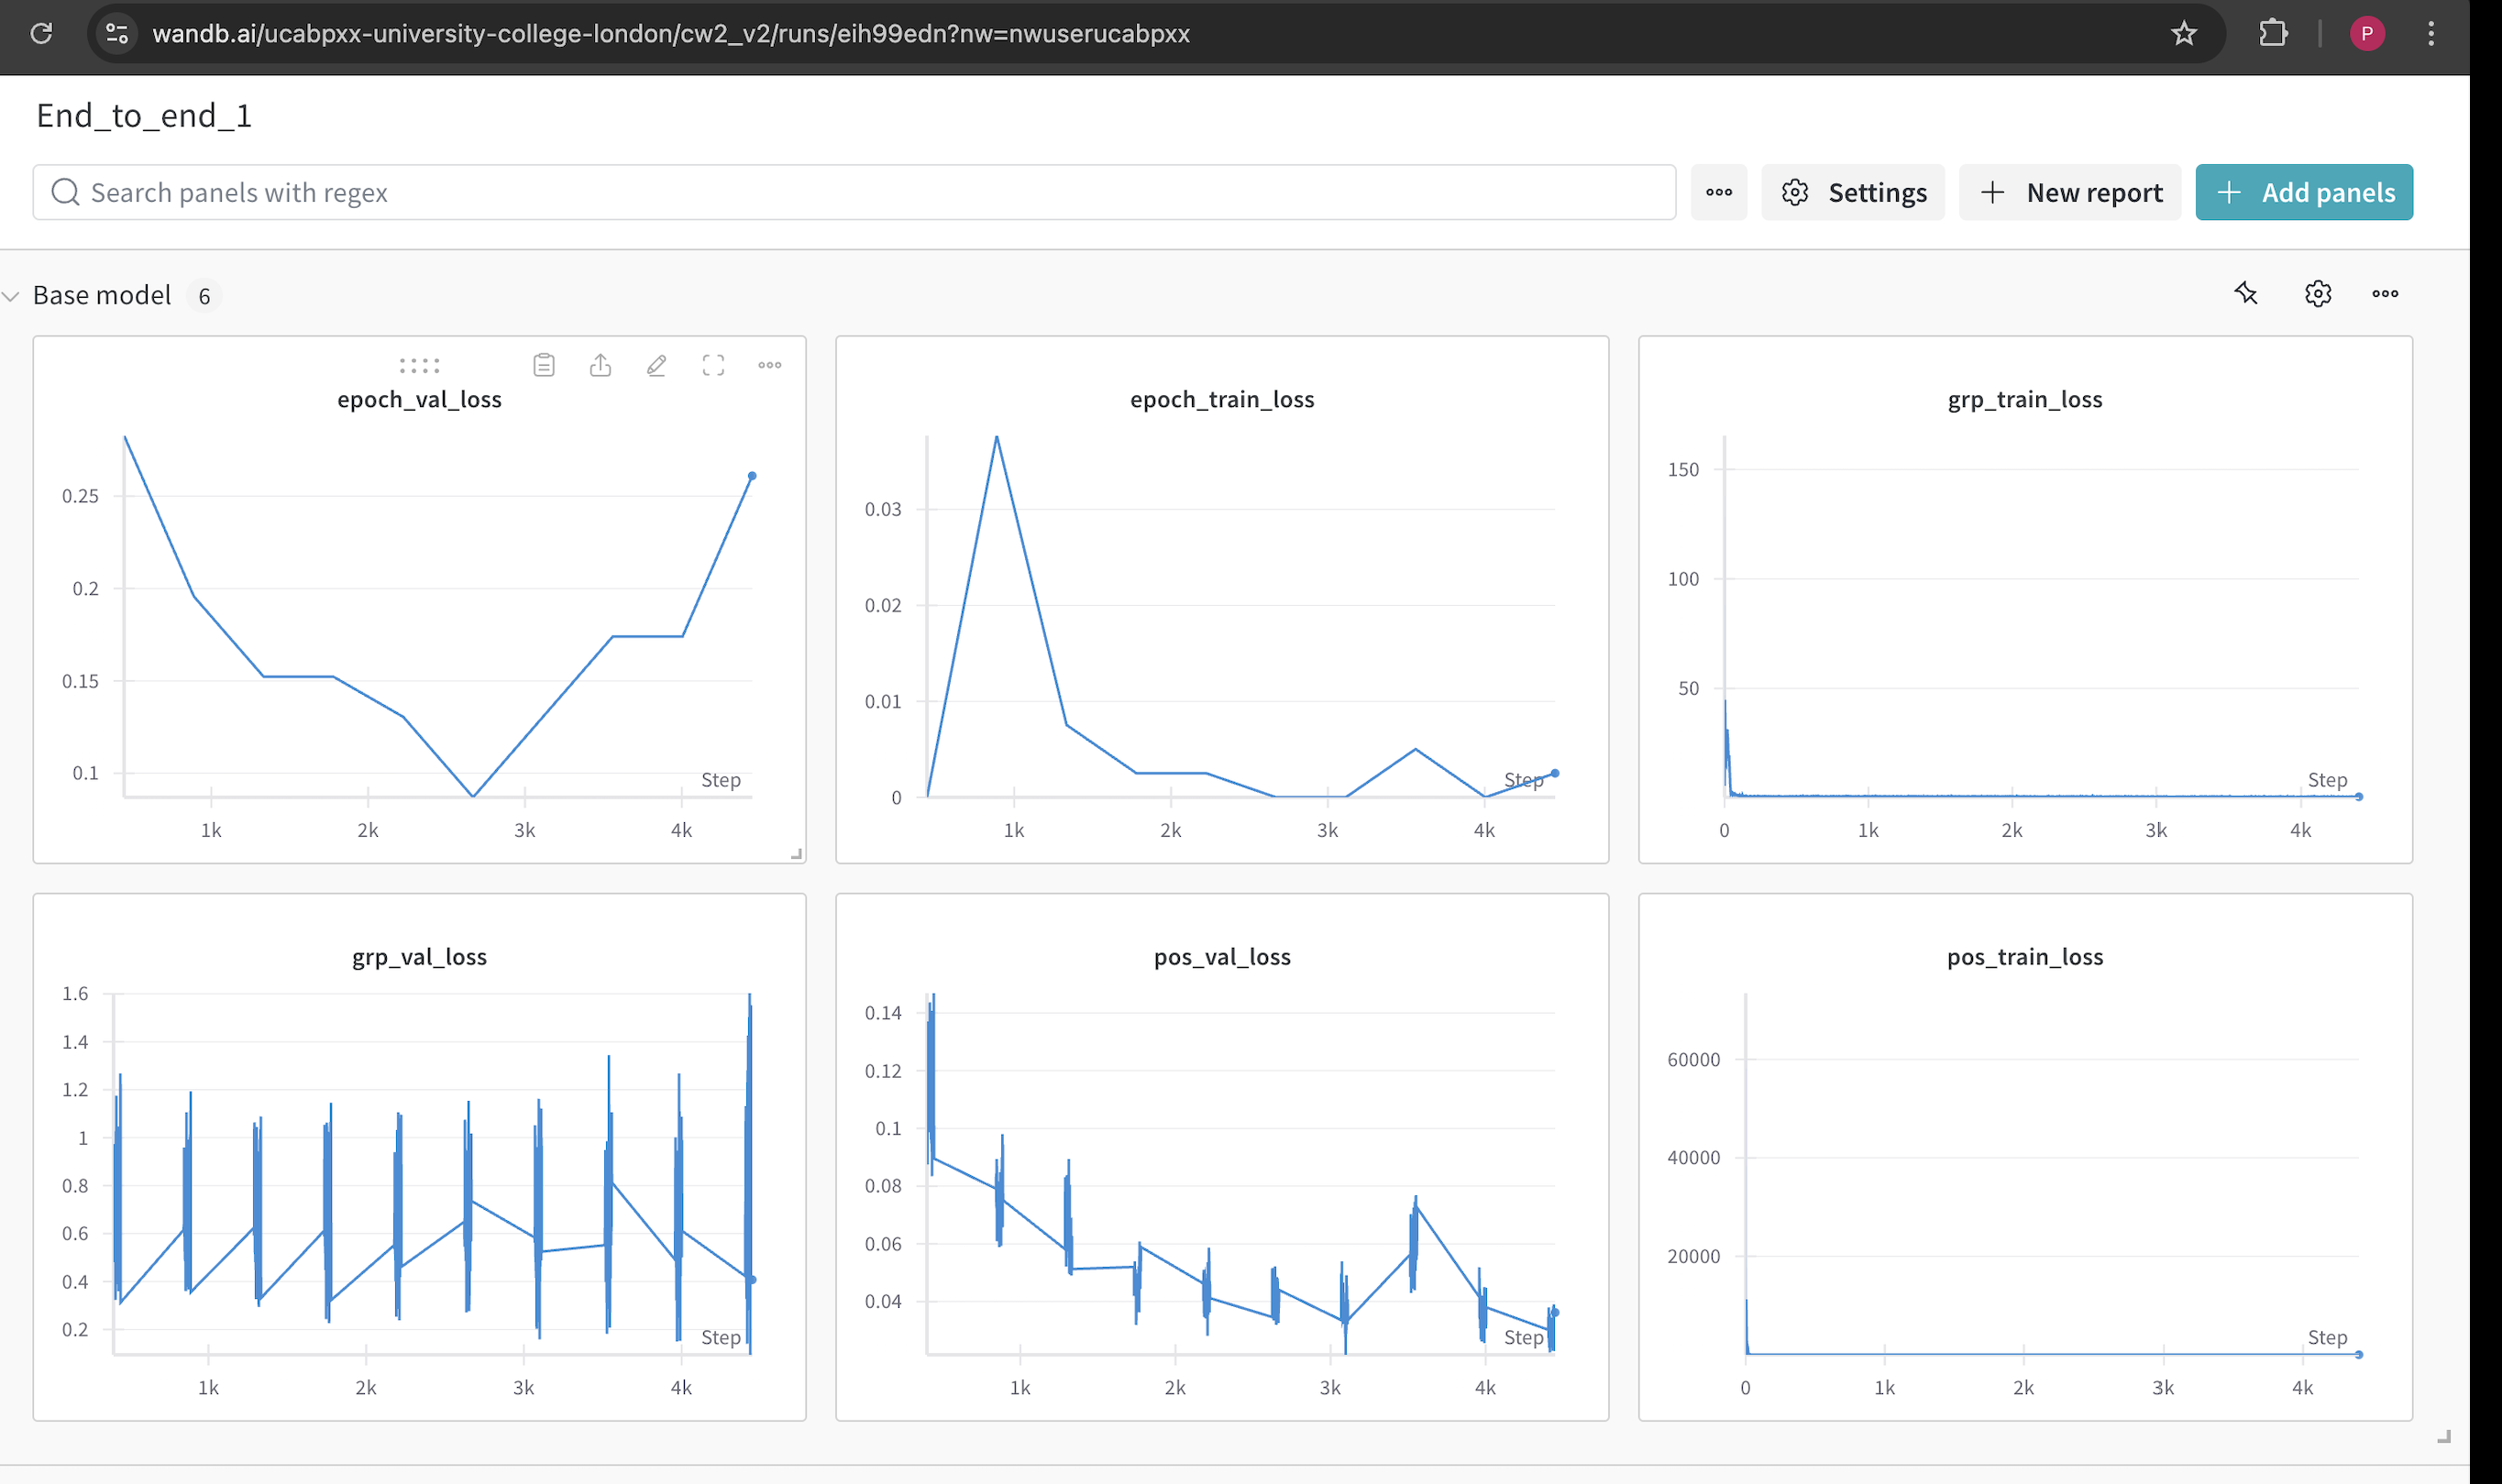


Both the training and validation metrics can be used to draw conclusions about how well the model performs.

The evaluation based on Training and Validation Losses suggests that the training loss starts at infinity in epoch 1, likely due to poor initialization, such as a learning rate of 0.001 and a batch size of 64. A high learning rate can cause the model to make excessively large weight updates, leading to unstable training and very high or infinite losses. Additionally, a batch size of 64 is ideal but relatively small for a large dataset, like the one used in behavioral cloning, and can cause instability by averaging less samples, and when combined with a high learning rate can amplifies the effects of unstable updates. Despite this, the training loss rapidly decreases and stabilizes around 0.0 from epoch 6 onward. The validation loss fluctuates, reaching its lowest point at 0.0870 in epoch 6 before increasing again in later epochs, reaching 0.2610 by epoch 10.  The model architecture, with its deep CNN layers and complex MLP structure, has the potential to perform well on both training and validation data, but it is also prone to overfitting when combined with high learning rate, instability in training dynamics, and loss of spatial features due to pooling. The fluctuating validation loss is likely a result of these complexities in addition to the learning rate and batch size, where the model may be overfitting to the training data or failing to generalize due to architectural choices like the large MLP layers or pooling-induced feature reduction.

Additional Metrics:

As seen in the run summary, the grp_train_loss value is at 0.5120 and can be seen in Figure .1 that it steadily decreases across epochs, eventually stabilizing at very low values, indicating effective learning for the gripper control task. However, the grp_val_loss, which values around 0.4076, fluctuates throughout the epochs, as seen in Figure 1, and remains higher than the training loss, suggesting that the model struggles with generalizing gripper control.

The pos_train_loss is at 0.03148 as given by run summary and it remains consistently low, as illustrated in Figure 1, while the pos_val_loss, which is at 0.03622 as given by run summary, shows a generally decreasing trend with some fluctuations between epochs but stays low overall, indicating good learning for positional control.

Interpretation:
Based on the result output of epochs and also as can be seen in the 'Figure .1' the model performs well on the training data, as evidenced by the sharp decrease in the training loss, showing it is successfully learning the data's patterns. However, the fluctuations in the validation loss point to potential overfitting or issues with generalization. The model excels in positional control, as indicated by the low and stable validation loss for position, but faces challenges in gripper control, reflected in the higher and more fluctuating validation loss for the gripper task.

Contextualizing the Performance:

Although the model demonstrates strong performance for positional control, the inconsistent performance on gripper control and fluctuating validation losses suggest that overfitting or instability may be affecting the model's ability to generalize for the gripper task. This indicates that further optimization or a more robust learning strategy is needed, especially to enhance gripper control. To address overfitting, techniques like normalization or dropout can be applied, and reducing the learning rate could improve the model's generalization. Additionally, adding more layers or increasing the network's complexity might enable the model to learn more intricate features, particularly for the gripper control task, which seems to be more challenging for the model to generalize.



#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should:
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.

#Answer -

To identify the model's failure modes, it is important to particularly focus on observations where the model performs poorly or inconsistently. A failure mode is evident in the gripper control task, as the grp_val_loss fluctuates across epochs, with relatively high values (0.4076) as can be interpreted from the run summary as well as the "Figure .1." This suggests that the model struggles to predict the correct gripper actions. Furthermore, the validation loss exhibits significant fluctuations from epochs 7 to 10 ranging from 0.1305 to 0.2610, indicating potential instability or overfitting.

The analysis based on the training run output and the "Figure.1" shows that the model's predictions for  gripper actions, like opening or closing, deviate from the ground truth, especially in the later stages of training. These failures have a considerable impact on the overall utility of the model, as the ability to control both position and gripper behavior is essential for real-world applications. The higher validation loss for gripper control indicates that the model isn't capturing the relationship between observations and gripper actions effectively.

The discrepancy between extremely low training loss which is near 0 and excatly 0 in epochs 6,7,9 and fluctuating validation loss suggests overfitting, meaning the model is unable to generalize well to unseen examples in the validation set. This failure is likely due to the complexity of learning both position and gripper actions simultaneously or possibly due to insufficient appropriate data for the gripper task. The validation loss fluctuations after epoch 6 further point to instability and poor generalization, which may be addressed with regularization techniques or adjustments to the model architecture.

The difficulties can be attributed to both the dataset's size and distribution, as well as the baseline model's architecture. With around 25,469 records, the dataset may not provide enough diverse or representative examples for the gripper control task which requires more complex learning. Additionally, the model's architecture, which uses a convolutional neural network (CNN) for image-based feature extraction and multi-layer perceptrons (MLPs) for encoding observations, may struggle with the complexity of simultaneously learning position and gripper actions. The relatively shallow network without any overfitting handling technique, consisting of a few convolutional layers followed by dense layers, may not have the capacity to capture the nuanced features needed for effective gripper control and causing the model to perform really well on train data but is not that effective on validation data.

The systematic failure in gripper control, highlighted by consistently higher and fluctuating grp_val_loss compared to positional control, demonstrates a clear and recurring issue across epochs. This indicates that the model is struggling to generalize on the gripper control task, despite performing well on positional control.

To address these challenges, techniques like hyperparameter tuning, regularization (e.g., dropout), and normalization can be employed, along with improvements to the model architecture, as discussed in section 1.b.ii.i.


### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ******* INSERT YOUR CODE HERE *******
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=16,  # Increased filters
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
        ),
        nn.ReLU(),
        nn.BatchNorm2d(16),  # Batch Normalization
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(
            in_channels=16,
            out_channels=32,  # Increased filters
            kernel_size=(3,3),
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.BatchNorm2d(32),  # Batch Normalization
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(
            in_channels=32,
            out_channels=64,  # Increased filters
            kernel_size=(3,3),
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.BatchNorm2d(64),  # Batch Normalization
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(
            in_channels=64,
            out_channels=128,  # Added more filters
            kernel_size=(3,3),
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.BatchNorm2d(128),  # Batch Normalization
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Dropout2d(p=0.2),


    ]
)

# Compute new output dimensions after the added CNN layers
_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
    (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
)

# Updated image encoder
image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[512, 256],  # Expanded MLP layers
        output_dim=128
    )
)

# Updated observation encoder with larger hidden layers
obs_encoder = MLP(
    input_dim=15,
    hidden_dims=[512, 256, 128],  # Expanded hidden layers for more representation
    output_dim=128,
    batch_norms=[True, True, True]  # Enable batch normalization for all layers
)

# Expanded dense layer for better fusion of features
dense = MLP(
    input_dim=128,
    hidden_dims=[256, 128, 64],  # Additional hidden layer for richer representation
    output_dim=6,
    batch_norms=[True, True, True]  # Enable batch normalization for all layers
)

# Updated model
class Baseline1(BaseModel):
    def __init__(
        self,
        image_encoder: JointCNNEncoder,
        obs_encoder: MLP,
        dense: MLP
    ) -> None:
        super().__init__()
        self.image_encoder = image_encoder
        self.obs_encoder = obs_encoder
        self.dense = dense

    def forward(self, images, obs):
        _img_enc = self.image_encoder(images)
        _obs_enc = self.obs_encoder(obs)
        _dense_enc = self.dense(_img_enc + _obs_enc)
        pos = _dense_enc[:, 0:3]
        grp = _dense_enc[:, 3:]
        return {
            "pos": pos,
            "grp": grp
        }

    def reset(
        self,
        image_encoder_kwargs,
        obs_encoder_kwargs,
        dense_kwargs
    ):
        self.image_encoder.reset(**image_encoder_kwargs)
        self.obs_encoder.reset(**obs_encoder_kwargs)
        self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model_1 = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

# ******* INSERT YOUR CODE HERE - END *******


In [ ]:
torch.manual_seed(1)
model_1.reset({},{},{})
exp_kwargs = {
    "batch_size": 100,
    "learning_rate": 0.0001,
    "half_precision": True,
    "target_offset": 0
}


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model_1.__repr__()


if exp_kwargs["half_precision"]:
    model_1 = model_1.half()
optimizer = torch.optim.Adam(
    model_1.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model_1 = model_1.cuda()
            with torch.autocast(device_type="cuda"):
                res = model_1(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model_1(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model_1 = model_1.cuda()
            res = model_1(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model_1(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


25469
torch.Size([100, 2, 224, 224])
torch.Size([100, 15])
torch.Size([100, 3])
torch.Size([100, 3])
tensor(3.0664, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model_1, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "Batch_Normalization"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 255/255 [02:05<00:00,  2.03it/s]
INFO:cw2_logger:epoch 1	 training loss : 0.64306640625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.13330078125 
INFO:cw2_logger:Running training epoch
100%|██████████| 255/255 [02:07<00:00,  2.00it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.0
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.0333251953125 
INFO:cw2_logger:Running training epoch
100%|██████████| 255/255 [02:08<00:00,  1.99it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.0
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.0333251953125 
INFO:cw2_logger:Running training epoch
100%|██████████| 255/255 [02:06<00:00,  2.01it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.0
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.0333251953125 
INFO:cw2_logger:Running training epoch
10

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example:
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

# Answer -


Figure .2.

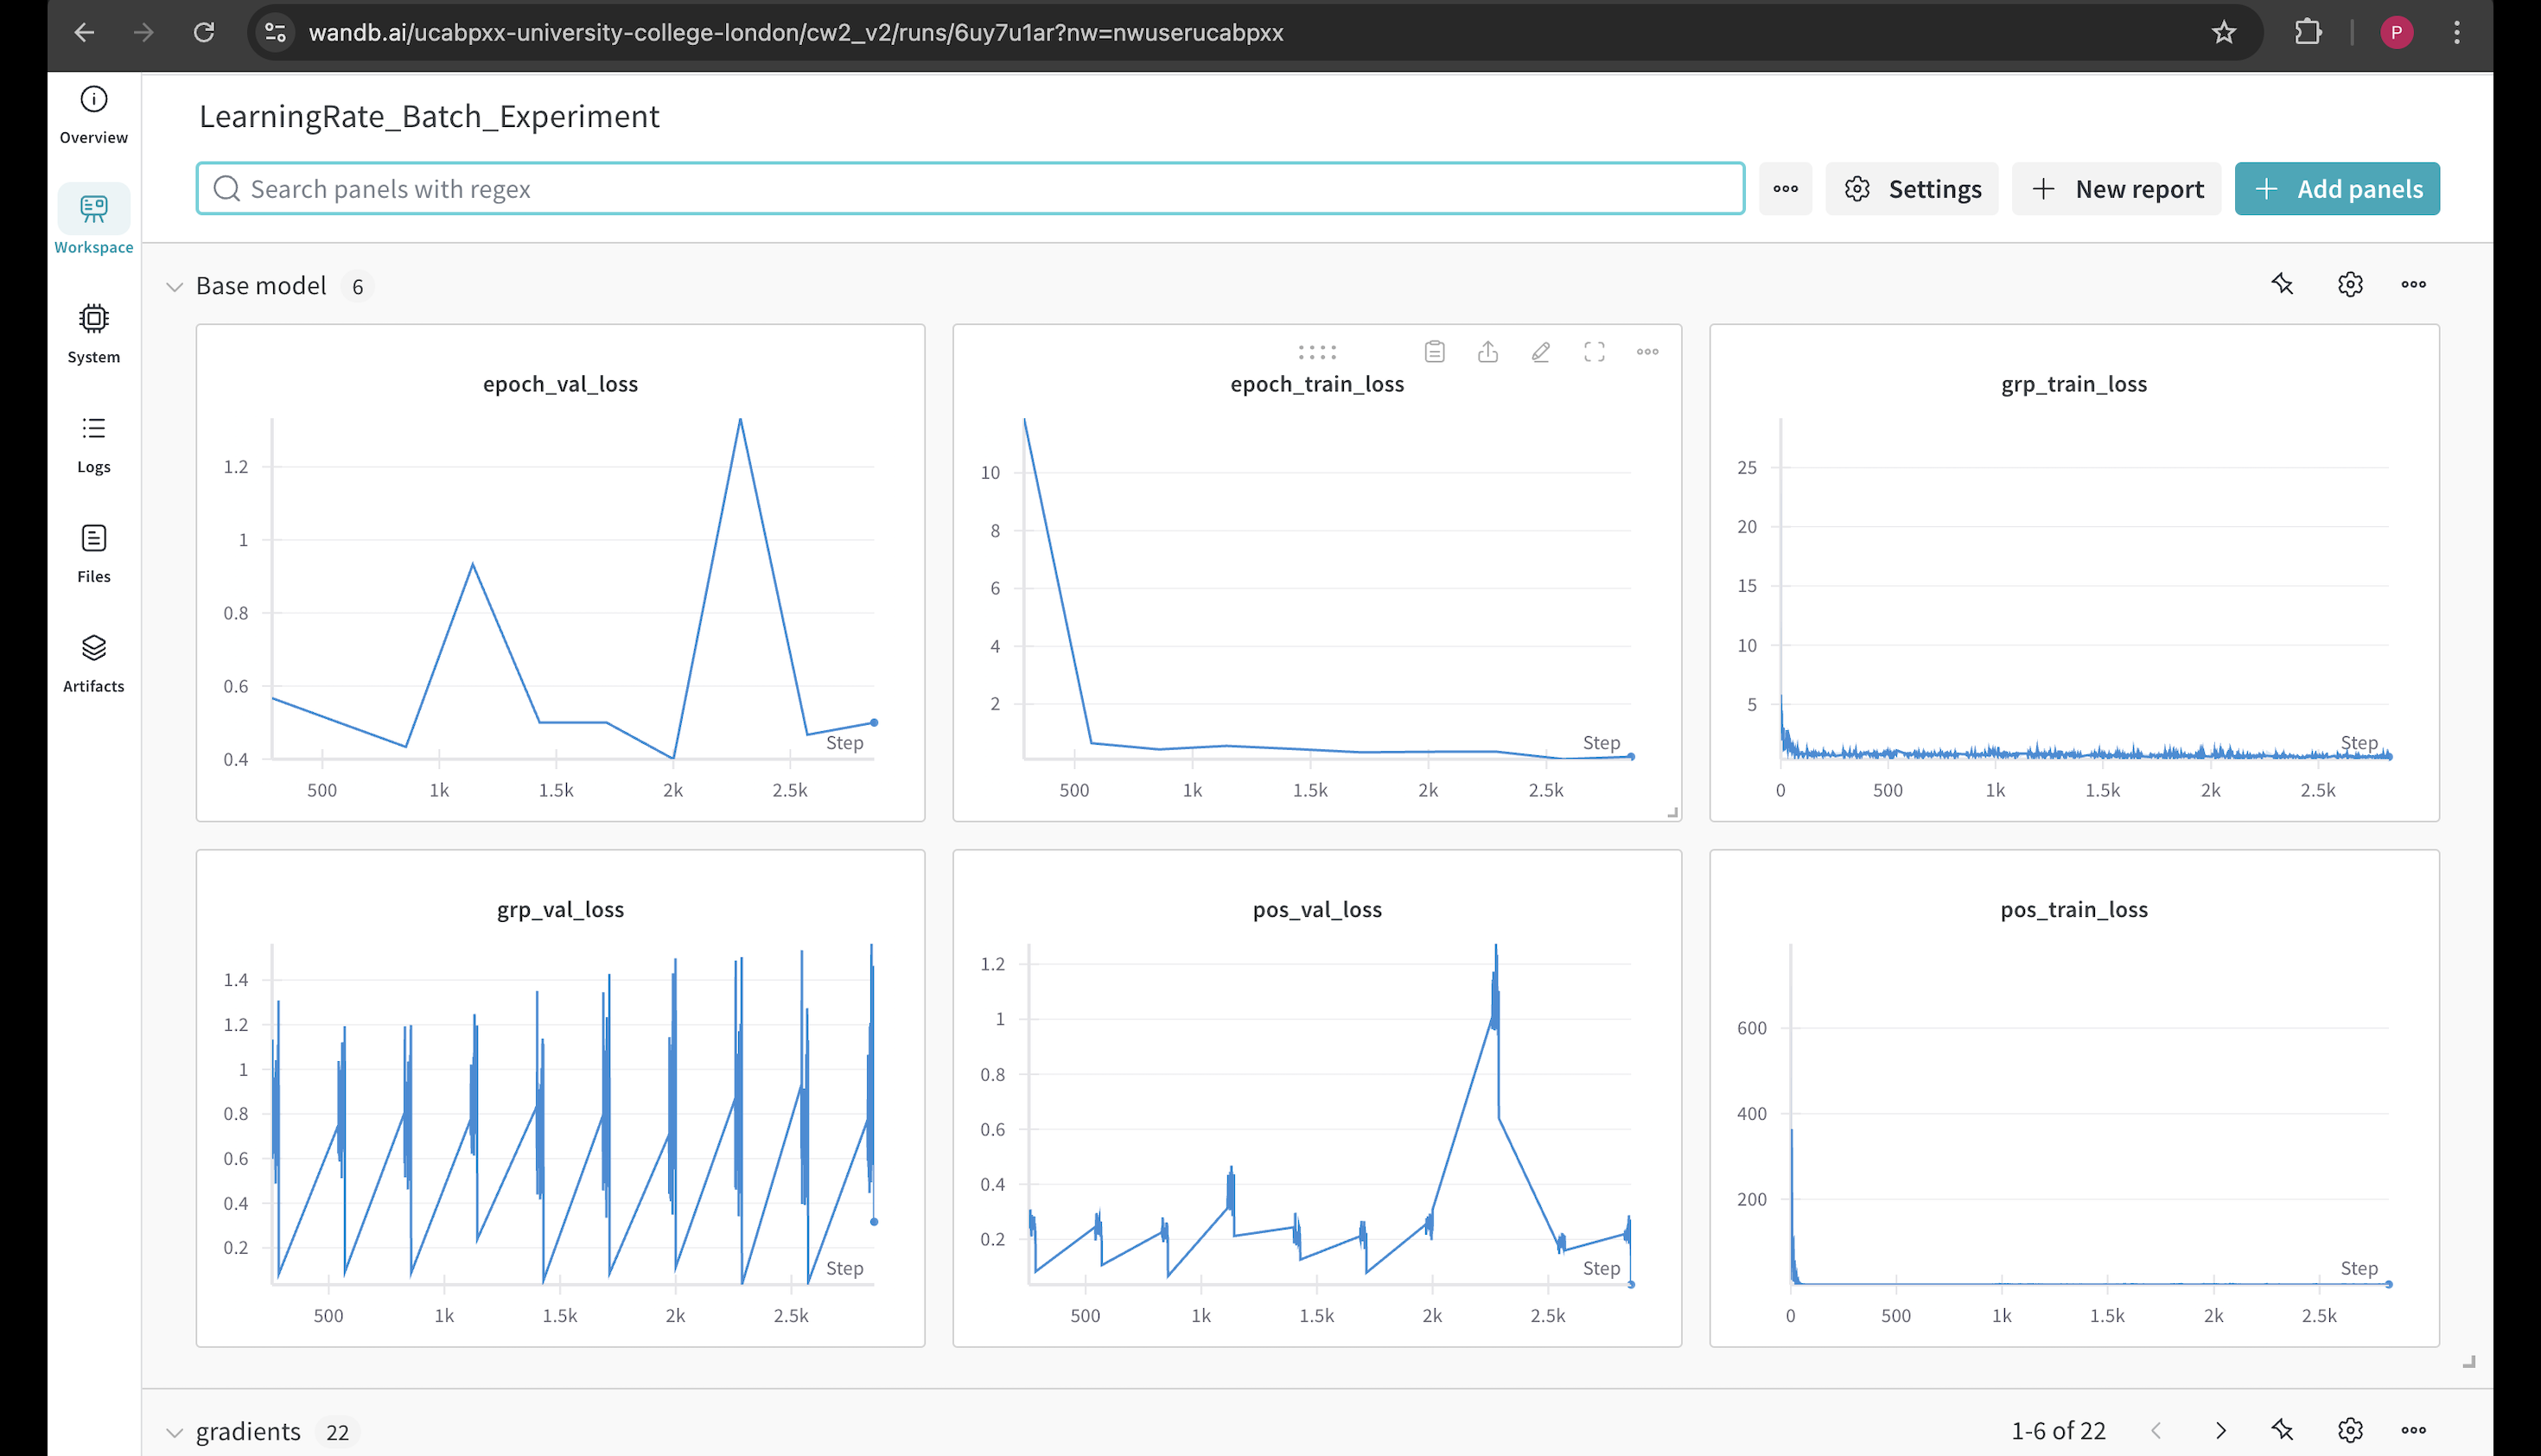


Result after decreasing the learning rate and increasing the batch size :



Epoch 1: Training Loss: 11.89, Validation Loss: 0.567

Epoch 2: Training Loss: 0.647, Validation Loss: 0.500

Epoch 3: Training Loss: 0.431, Validation Loss: 0.433

Epoch 4: Training Loss: 0.553,  Validation Loss: 0.933

Epoch 5: Training Loss: 0.447, Validation Loss: 0.500

Epoch 6: Training Loss: 0.329, Validation Loss: 0.500

Epoch 7: Training Loss: 0.349, Validation Loss: 0.399

Epoch 8: Training Loss: 0.353, Validation Loss: 1.333

Epoch 9: Training Loss: 0.094, Validation Loss: 0.467

Epoch 10: Training Loss: 0.177, Validation Loss: 0.500

##### Description


Lowering the learning rate and increasing the batch size -

In this experiment, I focused on hyperparameter tuning by decreasing the learning rate from 0.001 to 0.0001 and increased the batch size from 64 to 100 while keeping the model architecture and other parameters same. The key "delta" being measured in this experiment was the effect of changing the learning rate and batch size on the model's stability and generalization performance.

##### Justification


The motivation for conducting this experiment arose from the observation that the baseline model, which used a learning rate of 0.001 and batch size of 64, exhibited signs of overfitting and instability, especially in the gripper control task. Specifically, the model showed significant fluctuations in validation loss, despite a steady decrease in training loss as can be seen in Figure .1. Given the relatively high learning rate, I hypothesized that the model was possibly overshooting the optimal solution during training, causing it to overfit to the training data. Additionally, increasing the batch size was expected to smooth out gradient updates, potentially improving generalization by reducing the variance between updates. The context of the model development up to this point revealed that the model performed reasonably well on positional control but struggled to generalize to the gripper control task, which required more nuanced learning. This experiment was designed to address the overfitting issue and improve the stability of the model's performance.

After applying the decreased learning rate (0.0001) and increased batch size (100), the training loss was decreased steadily over epochs, starting at 11.89 in epoch 1 and ending at 0.18 by epoch 10 and can be infered from the result I have shared above as well as "Figure .2." which shows that training loss shows a sharp decline in the first few epoch till epoch 3 then slightly increased at epoch 4 and then again started to decrease and the stabilizes around a small value. The validation Loss showed fluctuations, ranging from 0.57 in epoch 1 to 1.33 in epoch 8, and ending at 0.5 in epoch 10 with lowest value at epoch 7 of 0.399.

The baseline model (with a learning rate of 0.001 and batch size of 64) which showed a steady decrease in training loss but at a faster rate compared to the modified experiment. The final training loss in the baseline model ended up slightly lower at 0.0025 than the experiment at 0.177. The validation loss of the baseline model fluctuated around 0.5 with fewer sharp spikes as can be infered from the Figure .2, but it still showed a similar pattern of instability in the later epochs, particularly in the gripper control task.
The experiment with a lower learning rate and larger batch size showed improved stability in training but still struggled with validation loss fluctuations, particularly with the gripper control task. However, on comparing "Figure .1" and "Figure .2", it can be seen that with high learning rate the validation loss started to increase after having a minmum at epoch 6 but with lower learning rate the validation loss showed fluctuations but finally showed a downward trend at the last epochs.

It can also be infered from "Figure .1" and "Figure 2." that grp_train_loss achieved a stable state in early epochs in both cases, and pos_val loss was also fluctuating but remained less at last epoch with lower learning rate.


##### Conclusion

From this experiment, I concluded that decreasing the learning rate and increasing the batch size helped improve the stability of training, as seen in the more gradual decrease in training loss in the Figure 2. However, the validation loss fluctuations indicate that while training stability improved, generalization still remained a challenge, especially for the gripper control task. The validation loss fluctuations at epochs 8-10 (as shown in the shared result above) suggest that overfitting or model complexity issues persisted. Therefore, while the changes in learning rate and batch size helped in stabilizing the training process, they were not sufficient to fully address the generalization problem in gripper control. Other factors, such as the architecture or the distribution of gripper-related data, might also be contributing to the failure to generalize effectively. These results suggest that further hyperparameter tuning, regularization techniques, or architectural improvements might be necessary to achieve better generalization and improve performance on the gripper control task.



#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

# Answer -

Figure 3 -  


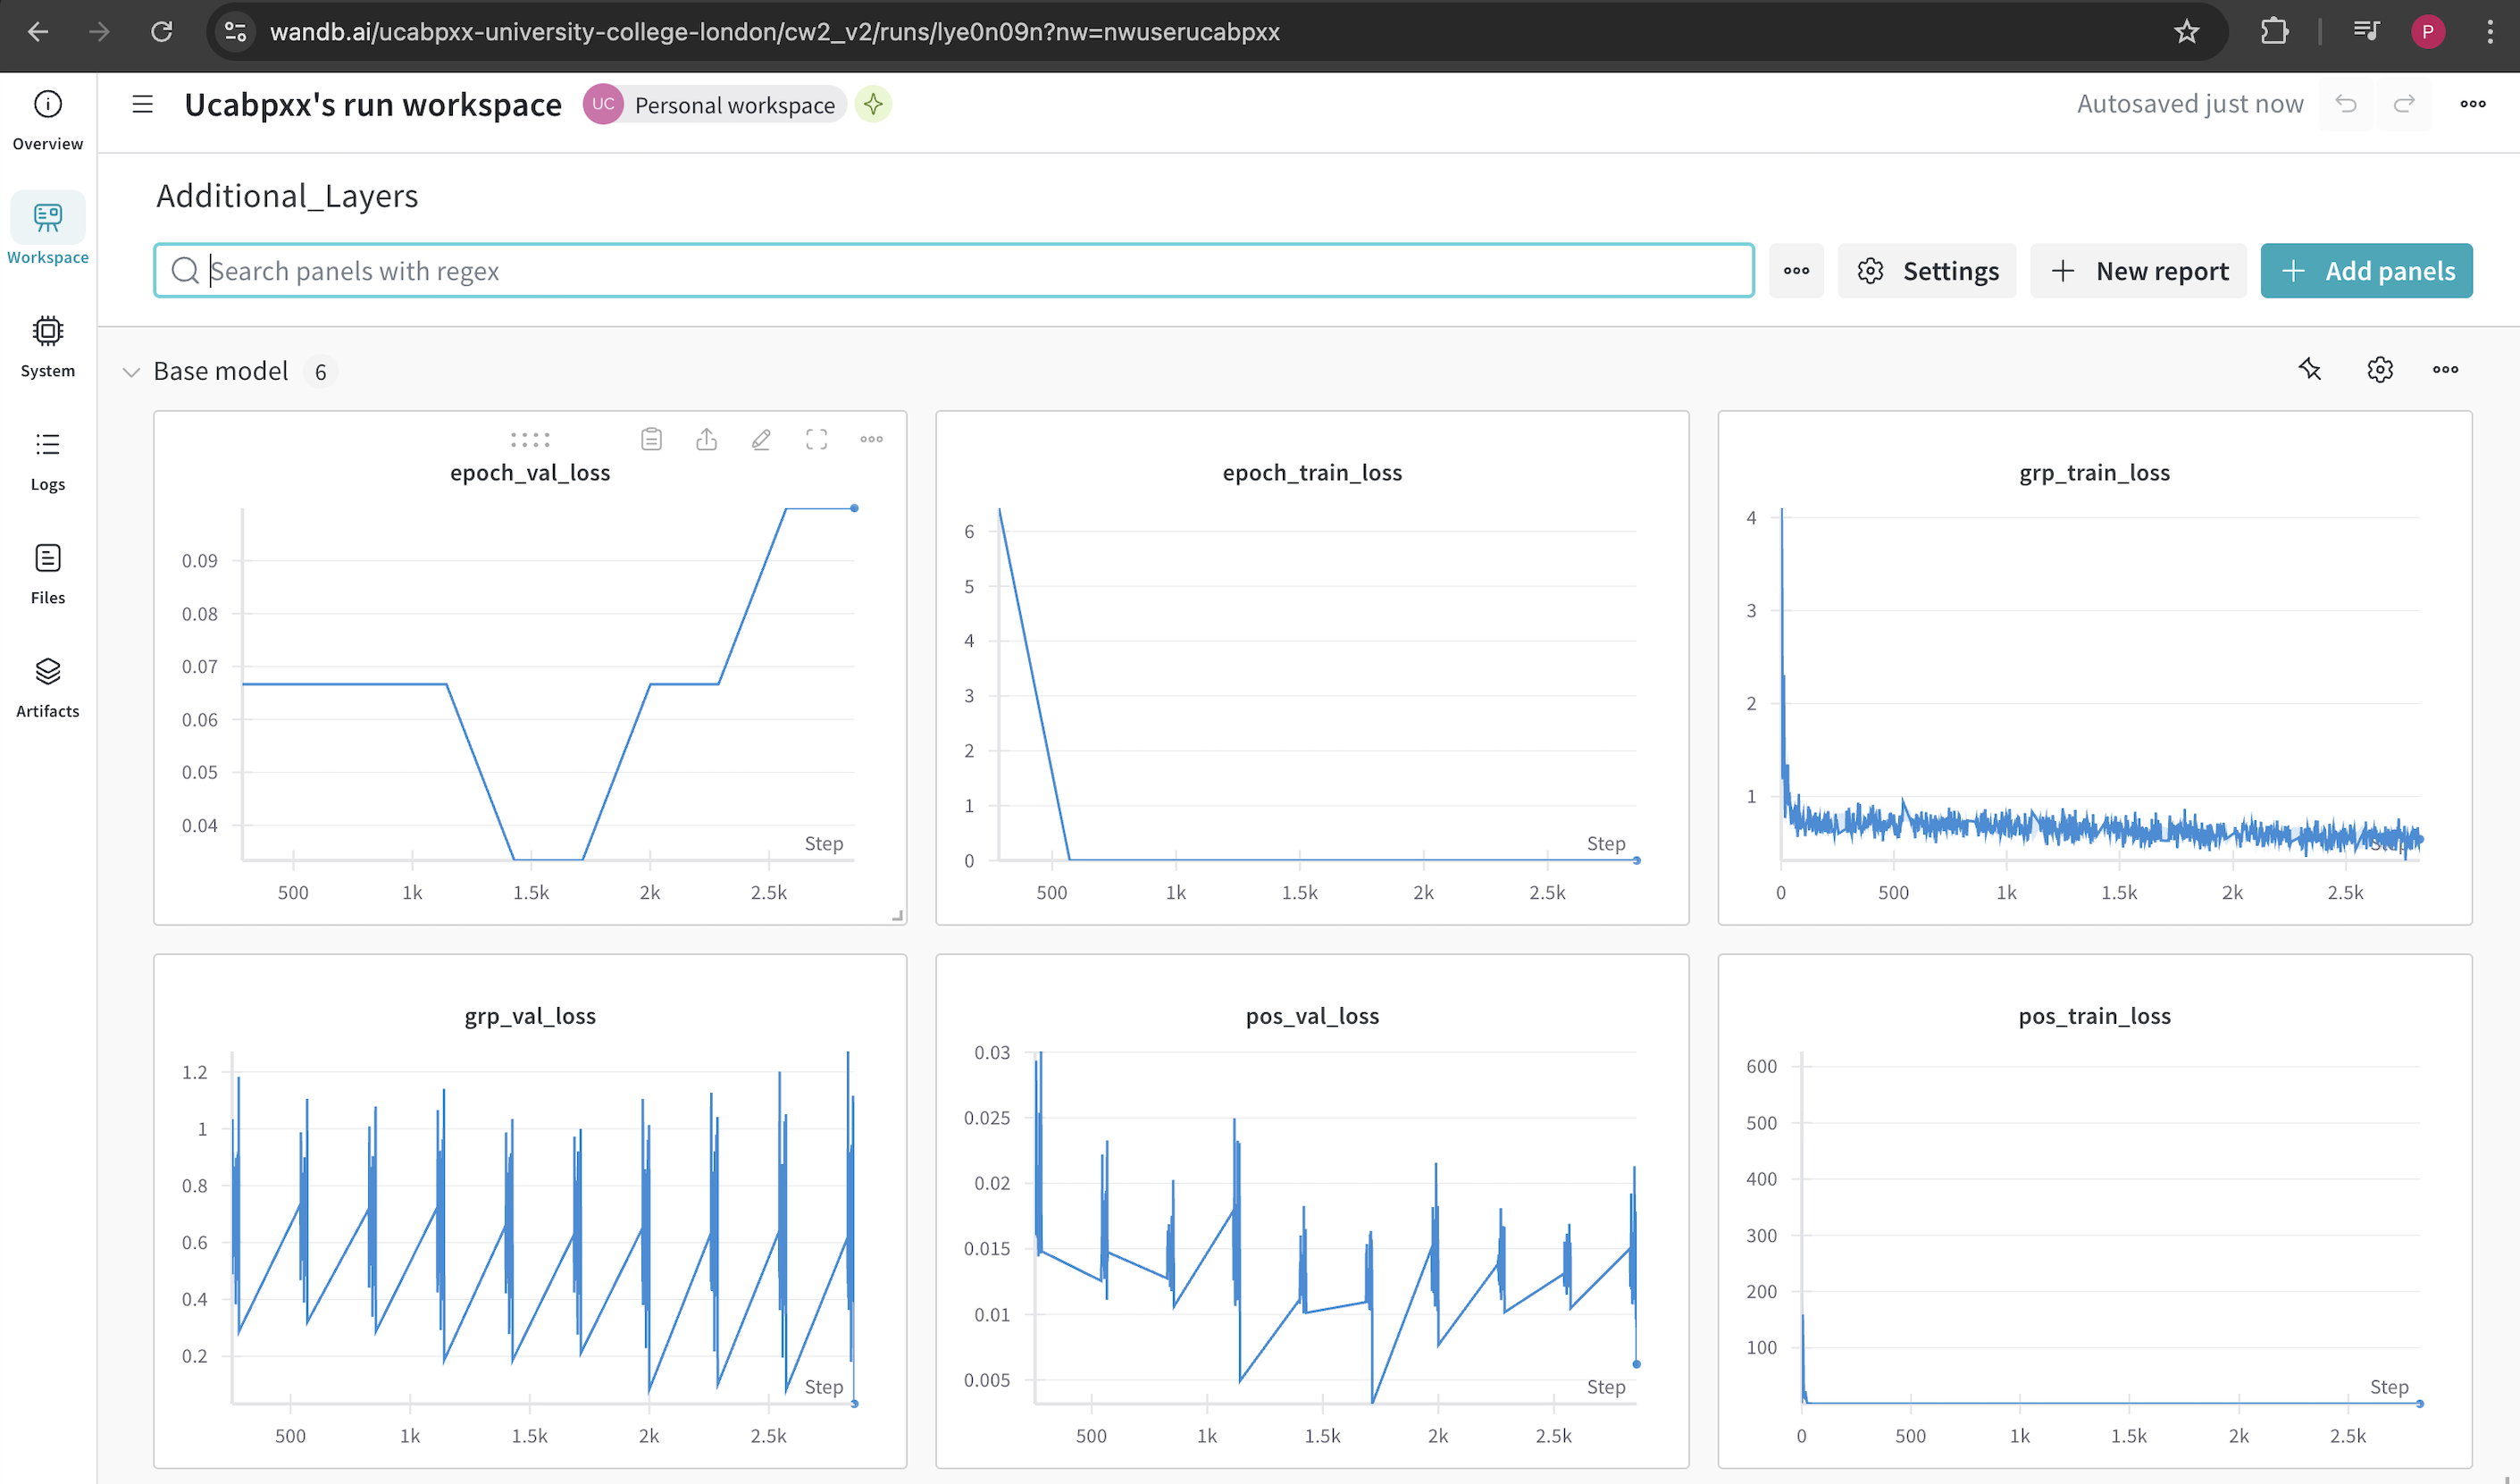


Results after adding more layers and filters in the model architecture -

Epoch 1: Training Loss: 6.426, Validation Loss: 0.067

Epoch 2: Training Loss: 0.000, Validation Loss: 0.067

Epoch 3: Training Loss: 0.000, Validation Loss: 0.067

Epoch 4: Training Loss: 0.000, Validation Loss: 0.067

Epoch 5: Training Loss: 0.000, Validation Loss: 0.033

Epoch 6: Training Loss: 0.000, Validation Loss: 0.033

Epoch 7: Training Loss: 0.000, Validation Loss: 0.067

Epoch 8: Training Loss: 0.000, Validation Loss: 0.067

Epoch 9: Training Loss: 0.000, Validation Loss: 0.100

Epoch 10: Training Loss: 0.000, Validation Loss: 0.100

##### Description


In this experiment, I have enhanced the model with additional layers and larger hidden dimensions to improve its expressive capability. Key modifications included the addition of a convolutional layer in the image encoder, increasing its depth from three layers in Baseline and Experiment 1 to four layers. The dense layers within the image encoder also featured increased hidden dimensions, transitioning from [256, 128] in Experiment 1 and Baseline implementation to [512,256,128]. Similarly, the observation encoder was expanded with an additional layer. The fusion layer was also made more complex, with greater depth and larger intermediate dimensions. The learning rate (0.0001) and batch size (100) from Experiment 1 were retained to maintain consistency.

##### Justification



In Experiment 2, I chose to enhance the model by adding additional layers and increasing the hidden dimensions to improve its expressive capacity. This decision stemmed from the insights gained in Experiment 1, where adjusting the learning rate and batch size did not yield significant improvements. The enhanced architecture in Experiment 2 included the addition of a convolutional layer in the image encoder, expanding its depth from three layers in Experiment 1 and the baseline to four layers, which allowed the model to better capture spatial features from the images. Additionally, I increased the size of the dense layers within the image encoder, transitioning from [256, 128] in Experiment 1 and the baseline to [512, 256, 128], which provided the model with a larger capacity to learn more complex patterns. The observation encoder was also expanded with an extra layer, and the fusion layer was made more complex by increasing its depth and intermediate dimensions. Retaining the learning rate (0.0001) and batch size (100) from Experiment 1 ensured consistency and allowed for a more stable training process. The result of these architectural enhancements was a significant improvement in validation loss, as seen in the consistent decrease to 0.0333 by epoch 5 and 6, compared to Experiment 1, where validation loss fluctuated and remained relatively high. Although Experiment 2 still exhibited some fluctuations in the pos_val_loss and grp_val_loss as can be seen in Figure .3, the range of these fluctuations was smaller than in Experiment 1, indicating that the additional layers and expanded model capacity helped reduce overfitting and allowed the model to generalize better to the validation set. This improvement justifies the changes made in Experiment 2 as they led to better performance, stability, and convergence when compared to Experiment 1.


##### Conclusion

Because of its increased ability to learn better feature hierarchies and capture meaningful representations, the new architecture performed better than both Experiment 1 and the baseline. The enhanced architecture used its design enhancements to effectively adapt to the decreased learning rate of 0.0001, whereas Experiment 1 experienced slower convergence and higher losses as a result of sensitivity to the decreased learning rate and increased batch size.
Since we improved the architecture, it performed well with a low learning rate because the added layers and larger hidden dimensions enhanced the model's capacity to capture more complex features and relationships in the data. This increased capacity allowed the model to adapt effectively to smaller learning rate updates, as it could retain and process important information more efficiently. The enhanced architecture made the model more stable during training, enabling it to learn better even with the reduced learning rate, which might have hindered the convergence in models with less capacity.
Despite employing the same learning rate as Experiment 1, this enabled it to perform better by generalising more effectively, extracting more robust features, and reducing overfitting to some extent. However, the overall performance of the model has improved than in experiment 1 and baseline but it still needs improvement. The graphs in Figure.3 also indicated overfitting in the model as the training loss decreases significantly, but the validation loss plateaus or increases, which means that the model is memorizing the training data rather than learning generalizable patterns. This could be due to insufficient training data, an overly complex model, or a lack of regularization. Also, the validation loss for position prediction also decreases, but at a slower rate than the training loss, suggesting some overfitting. Lastly, the gripper train loss decreases significantly but the validation loss keeps fluctuating and increasing at end epochs again suggesting overfitting and poor generalization. To further address the fluctuation of validation loss for grp_val_loss and pos_val_loss which suggest overfitting other techniques like batch normalization for normalizing and dropout can ab applied given the huge size of the dataset.



#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

# Answer -

Figure 4.

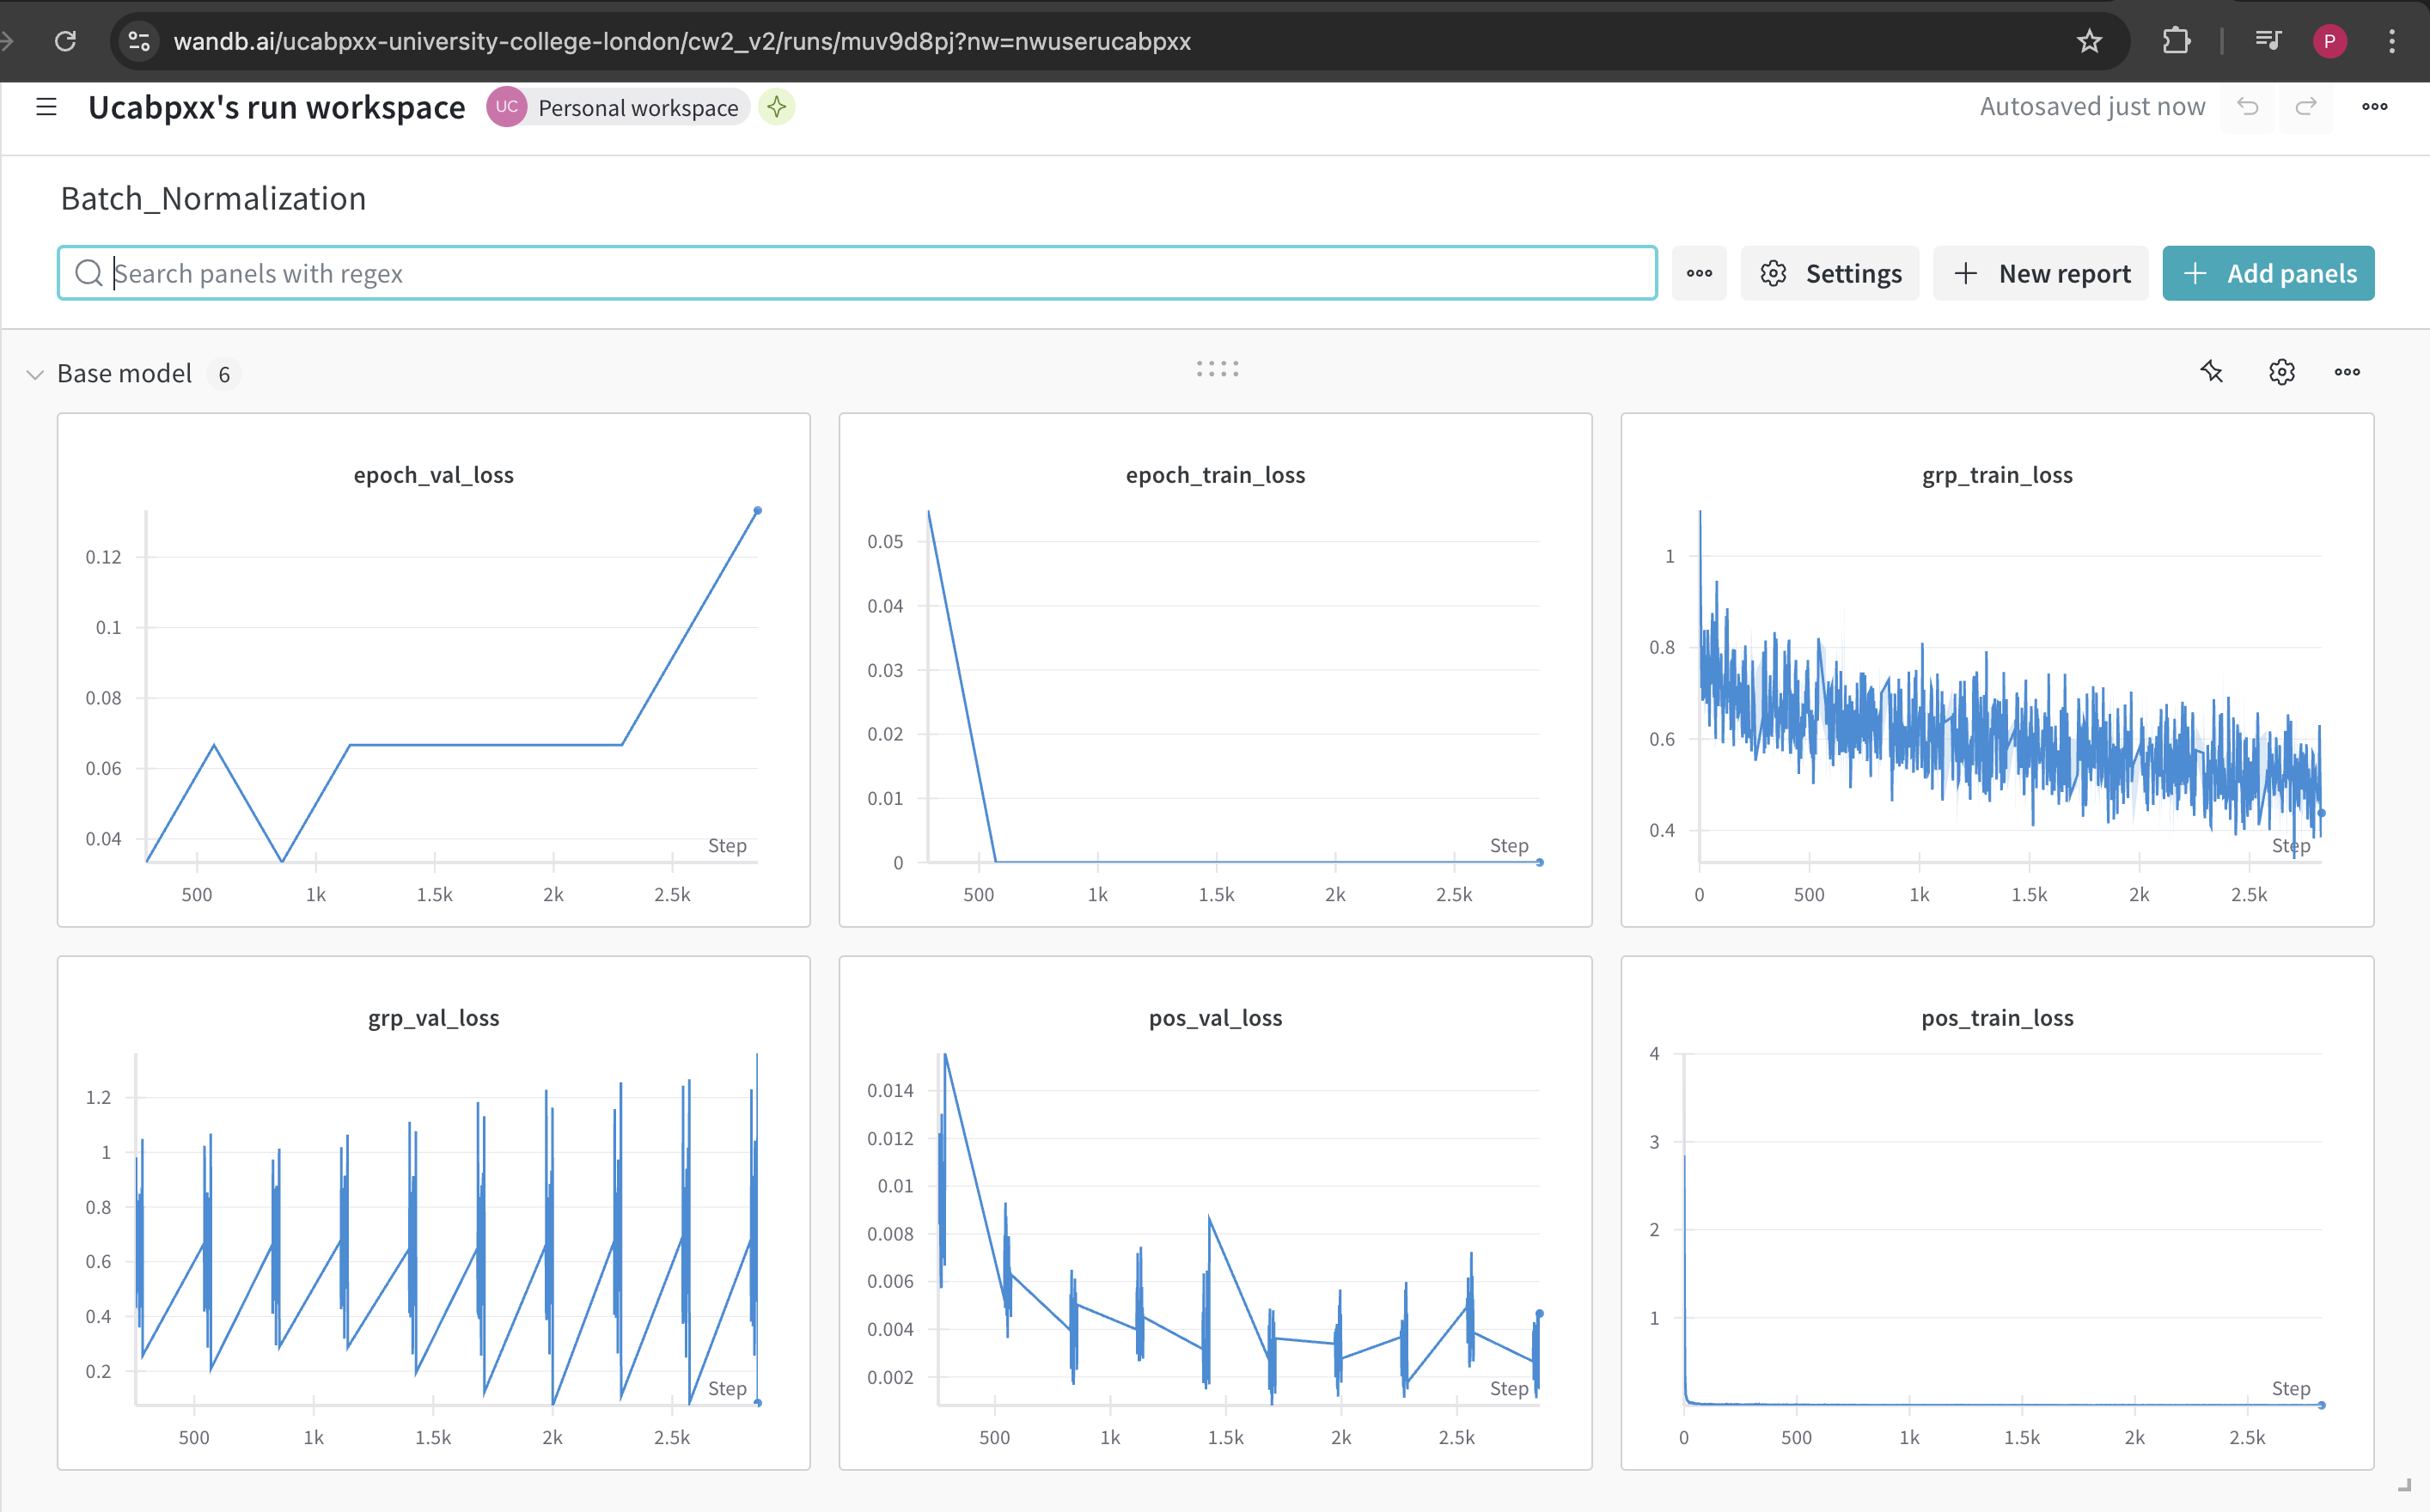



Result after adding dropout and normalization :

Epoch 1: Training Loss: 0.643, Validation Loss: 0.133

Epoch 2: Training Loss: 0.0, Validation Loss: 0.033

Epoch 3: Training Loss: 0.0, Validation Loss: 0.033

Epoch 4: Training Loss: 0.0, Validation Loss: 0.033

Epoch 5: Training Loss: 0.0, Validation Loss: 0.067

Epoch 6: Training Loss: 0.0, Validation Loss: 0.067

Epoch 7: Training Loss: 0.0, Validation Loss: 0.067

Epoch 8: Training Loss: 0.353, Validation Loss: 0.099

Epoch 9: Training Loss: 0.0, Validation Loss: 0.067

Epoch 10: Training Loss: 0.0, Validation Loss: 0.133

##### Description

In Experiment 3, I incorporated batch normalization and dropout based on insights from earlier experiments, where fluctuations in the position and gripper validation losses were still observed despite the changes made in Experiments 1 and 2. These fluctuations suggested that the model might still be overfitting, prompting the inclusion of these techniques to improve training dynamics and enhance generalization. Alongside these additions, I retained the modifications introduced in Experiments 1 and 2. The objective was to evaluate the cumulative impact of these combined changes on the model’s training stability, convergence behavior, and overall performance across both the training and validation datasets.

##### Justification

In Experiment 3, I plan to include Batch Normalization and Dropout based on insights gained from the previous experiments. In Experiment 1, reducing the learning rate helped with convergence but also revealed challenges with overfitting and slower training. Meanwhile, Experiment 2 showed good results but can be seen in Figure 3., that increasing model complexity led to fluctuations in validation loss, suggesting instability and overfitting. To address these issues, BatchNorm will help stabilize training by normalizing activations, leading to smoother convergence, while Dropout will prevent overfitting by introducing regularization. These additions are aimed at improving model stability and generalization, ensuring better performance in Experiment 3. It can be seen from the results and the Figure 4, that the training loss reduced significantly and the validation loss was fluctuating but still wasn't very large and the result I have shared above showed that the validation loss (0.099) at epoch 8 was less than the training loss(0.353) which means the model was able to generalize well at epoch 8.


##### Conclusion

As observed in Experiment 2, the model initially exhibited a high training loss that quickly dropped to zero, while the validation loss fluctuated between 0.033 and 0.1, with little improvement after the initial drop. This pattern suggested that the model may have been overfitting to the training data, as the training loss reached zero while the validation loss remained relatively high and unstable. To address this, Batch Normalization and Dropout were introduced in Experiment 3. In this experiment, the inclusion of these techniques led to more varied results during the early epochs, with the training loss starting at 0.643 in the first epoch and then steadily decreasing to zero. However, the validation loss still showed some fluctuations which was similar to experiment 2. For example, the validation loss stabilized more frequently at 0.033, with occasional increases to 0.067 or 0.099. This suggests that the model still faces overfitting and the regularization techniques didn't helped much to reduce the severity of this issue compared to Experiment 2.

Figure 4 further supports this observation, as the model performed well on the training data, with consistently low training loss across epochs, including grp and val train loss. However, the grp val loss displayed an increasing, fluctuating trend, similar to Experiment 2, indicating the need for additional techniques to better manage this issue. On the other hand, the pos_val_loss in the "Figure .4." showed a downward trend similar to Experiment 2 suggesting that while improvements were made, the model is able to generalize well on pos_grp_loss.

The model in Experiment 3 still performed better than the baseline and and than Experiment 1, but its results remained very close to Experiment 2 as can be seen from Figure 1,2,3 and 4 and the result data I included for all.

In conclusion, the addition of Batch Normalization and Dropout in Experiment 3 appears to have contributed to slightly improved model stability during training, though overfitting and fluctuations in the validation loss remain almost the same. The training process seems to benefit from smoother convergence, but further adjustments might still be needed to achieve optimal generalization as these two techniques wasnt very effective.

Also, overall experiment 2 proved to be the most successful compared to the other experiments I conducted, as evidenced by the results I have shared above.

Note : I have changed the name of the wandb test results with respect to the experiment I was conducting thats why the graphs have different name but my account name can be cross checked to check the genuinity.



### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
torch.manual_seed(1)

exp_kwargs = {
    "batch_size": 50,
    "learning_rate": 0.0001,
    "half_precision": True,
    "target_offset": 0,
    "beta":8,
    "num_epochs":30,
    "latent_dim": 128,

}



train_dataset = NpDictDataset(
    array_dict=train_nps,
    #transform_lkp=global_transforms,
    dep_vars=[],
    indep_vars=[
        "front_cam_ob", "mount_cam_ob"
    ],
    target_offset=0
)

val_dataset = NpDictDataset(
    array_dict=val_nps,
    #transform_lkp=global_transforms,
    dep_vars=[],
    indep_vars=[
        "front_cam_ob", "mount_cam_ob"
    ],
    target_offset=0
)


def collate_func_1(input_list: List[DatasetOutput]) -> DatasetOutput:
    front_images = []
    mount_images = []

    for val in input_list:
        # Apply transformations for images only
        front_cam_ob = global_transforms["front_cam_ob"](val.input["front_cam_ob"])
        mount_cam_ob = global_transforms["mount_cam_ob"](val.input["mount_cam_ob"])

        # Appending front and mount camera images to respective lists
        front_images.append(front_cam_ob[None, :])  # Adding batch dimension
        mount_images.append(mount_cam_ob[None, :])  # Adding batch dimension

    return DatasetOutput(
        input={
            "front_images": torch.concat(front_images, dim=0),
            "mount_images": torch.concat(mount_images, dim=0),
        },
        output={}
    )

# Initialize DataLoader with batch size and collate function
train_dataloader_1 = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func_1,
)

val_dataloader_1 = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func_1,
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_VAE(nn.Module):
    def __init__(self, latent_dim):
        super(CNN_VAE, self).__init__()

        # Front image encoder
        self.front_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, latent_dim)
        )

        # Mount image encoder
        self.mount_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, latent_dim)
        )

        # Latent space representation
        self.fc_mu = nn.Linear(latent_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim * 2, latent_dim)

        # Enhanced Decoder for reconstruction
        self.decoder_fc = nn.Linear(latent_dim, 128 * 28 * 28)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, front_images, mount_images):

        # Encoding front and mount images separately
        front_latent = self.front_encoder(front_images)
        mount_latent = self.mount_encoder(mount_images)
        # Concatenatenating latents from both encoders
        combined_latent = torch.cat([front_latent, mount_latent], dim=-1)
        mu = self.fc_mu(combined_latent)
        logvar = self.fc_logvar(combined_latent)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterizing latent vector
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Decoding the latent representation
        fc_output = self.decoder_fc(z)
        fc_output = fc_output.view(-1, 128, 28, 28)
        decoded = self.decoder_conv(fc_output)
        return decoded

    def forward(self, front_images, mount_images):
        # Encoding images
        mu, logvar = self.encode(front_images, mount_images)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar


In [ ]:
def loss_function_VAE(decoded, original_images, mu, logvar, beta):

    reconstruction_loss = F.mse_loss(decoded, original_images, reduction='sum')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss with beta scaling for KL divergence
    total_loss = reconstruction_loss + beta * kl_loss
    return reconstruction_loss, kl_loss, total_loss



In [ ]:
# Set device (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
vae_model = CNN_VAE(exp_kwargs["latent_dim"]).to(device)

# Optimizer initialization
optimizer = optim.Adam(vae_model.parameters(), exp_kwargs["learning_rate"])

# Plotting function
def plot_losses(train_reconstruction_losses, train_KL_losses, train_tot_losses,
                eval_reconstruction_losses, eval_KL_losses, eval_tot_losses, num_epochs):
    epochs = range(1, num_epochs + 1)  # Define epochs based on the number of epochs

    fig, axs = plt.subplots(3, 1, figsize=(10, 18))

    # Total Loss
    axs[0].plot(epochs, train_tot_losses, "-ro", label="Train")
    axs[0].plot(epochs, eval_tot_losses, "-bo", label="Test")
    axs[0].set_title("Total Loss")
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss per Sample')
    axs[0].legend()
    axs[0].grid(True)

    # Reconstruction Loss
    axs[1].plot(epochs, train_reconstruction_losses, "-ro", label="Train")
    axs[1].plot(epochs, eval_reconstruction_losses, "-bo", label="Test")
    axs[1].set_title("Reconstruction Loss")
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss per Sample')
    axs[1].legend()
    axs[1].grid(True)

    # KL Divergence Loss
    axs[2].plot(epochs, train_KL_losses, "-ro", label="Train")
    axs[2].plot(epochs, eval_KL_losses, "-bo", label="Test")
    axs[2].set_title("KL Divergence Loss")
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Loss per Sample')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


def train_vae(model, train_dataloader, val_dataloader, optimizer, num_epochs, device='cuda'):

    train_reconstruction_losses = []
    train_KL_losses = []
    train_tot_losses = []

    eval_reconstruction_losses = []
    eval_KL_losses = []
    eval_tot_losses = []

    model.train()
    for epoch in range(num_epochs):
        epoch_reconstruction_loss = 0
        epoch_KL_loss = 0
        epoch_tot_loss = 0

        # Training phase
        for batch_idx, batch in enumerate(train_dataloader):
            front_images = batch.input['front_images'].to(device)
            mount_images = batch.input['mount_images'].to(device)
            optimizer.zero_grad()
            # Forward pass
            decoded, mu, logvar = model(front_images, mount_images)
            # Loss comoutation using beta vae loss fn
            reconstruction_loss, kl_loss, total_loss = loss_function_VAE(decoded, front_images, mu, logvar, exp_kwargs["beta"])
            # Backpropagation
            total_loss.backward()
            # Optimize
            optimizer.step()
            # Accumulating losses for the current batch
            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_KL_loss += kl_loss.item()
            epoch_tot_loss += total_loss.item()

        # Average training losses for the epoch
        train_reconstruction_losses.append(epoch_reconstruction_loss / len(train_dataloader))
        train_KL_losses.append(epoch_KL_loss / len(train_dataloader))
        train_tot_losses.append(epoch_tot_loss / len(train_dataloader))
        print(f'Epoch [{epoch+1}/{exp_kwargs["num_epochs"]}], Training Loss: {train_tot_losses[-1]:.4f}, '
              f'Recon Loss: {train_reconstruction_losses[-1]:.4f}, KL Loss: {train_KL_losses[-1]:.4f}')

        # Validation phase
        model.eval()
        eval_reconstruction_loss = 0
        eval_KL_loss = 0
        eval_tot_loss = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                front_images = batch.input['front_images'].to(device)
                mount_images = batch.input['mount_images'].to(device)

                decoded, mu, logvar = model(front_images, mount_images)

                reconstruction_loss, kl_loss, total_loss = loss_function_VAE(decoded, front_images, mu, logvar, exp_kwargs["beta"])

                # Accumulating validation losses
                eval_reconstruction_loss += reconstruction_loss.item()
                eval_KL_loss += kl_loss.item()
                eval_tot_loss += total_loss.item()

        # Average validation losses
        eval_reconstruction_losses.append(eval_reconstruction_loss / len(val_dataloader))
        eval_KL_losses.append(eval_KL_loss / len(val_dataloader))
        eval_tot_losses.append(eval_tot_loss / len(val_dataloader))
        print(f'Epoch [{epoch+1}/{exp_kwargs["num_epochs"]}], Validation Loss: {eval_tot_losses[-1]:.4f}, '
              f'Recon Loss: {eval_reconstruction_losses[-1]:.4f}, KL Loss: {eval_KL_losses[-1]:.4f}')

        # Model stetting back to training mode to ensure the model switches back to training behavior
        model.train()

    return train_reconstruction_losses, train_KL_losses, train_tot_losses, eval_reconstruction_losses, eval_KL_losses, eval_tot_losses

# Example usage
train_reconstruction_losses, train_KL_losses, train_tot_losses, eval_reconstruction_losses, eval_KL_losses, eval_tot_losses = train_vae(vae_model, train_dataloader_1, val_dataloader_1, optimizer, exp_kwargs["num_epochs"], device=device)



Epoch [1/30], Training Loss: 4333351.7150, Recon Loss: 4317812.2191, KL Loss: 1942.4365
Epoch [1/30], Validation Loss: 4173211.7998, Recon Loss: 4162805.1164, KL Loss: 1300.8338
Epoch [2/30], Training Loss: 4226683.6127, Recon Loss: 4215429.7946, KL Loss: 1406.7266
Epoch [2/30], Validation Loss: 4191181.3876, Recon Loss: 4179946.5773, KL Loss: 1404.3497
Epoch [3/30], Training Loss: 4217720.2400, Recon Loss: 4204511.1326, KL Loss: 1651.1369
Epoch [3/30], Validation Loss: 4131964.5147, Recon Loss: 4118184.3556, KL Loss: 1722.5186
Epoch [4/30], Training Loss: 4208074.6010, Recon Loss: 4193602.5186, KL Loss: 1809.0102
Epoch [4/30], Validation Loss: 4135696.0324, Recon Loss: 4120978.4039, KL Loss: 1839.7007
Epoch [5/30], Training Loss: 4188484.6488, Recon Loss: 4173217.7417, KL Loss: 1908.3627
Epoch [5/30], Validation Loss: 4111821.6042, Recon Loss: 4096333.2103, KL Loss: 1936.0479
Epoch [6/30], Training Loss: 4183854.5199, Recon Loss: 4168008.6623, KL Loss: 1980.7331
Epoch [6/30], Validati

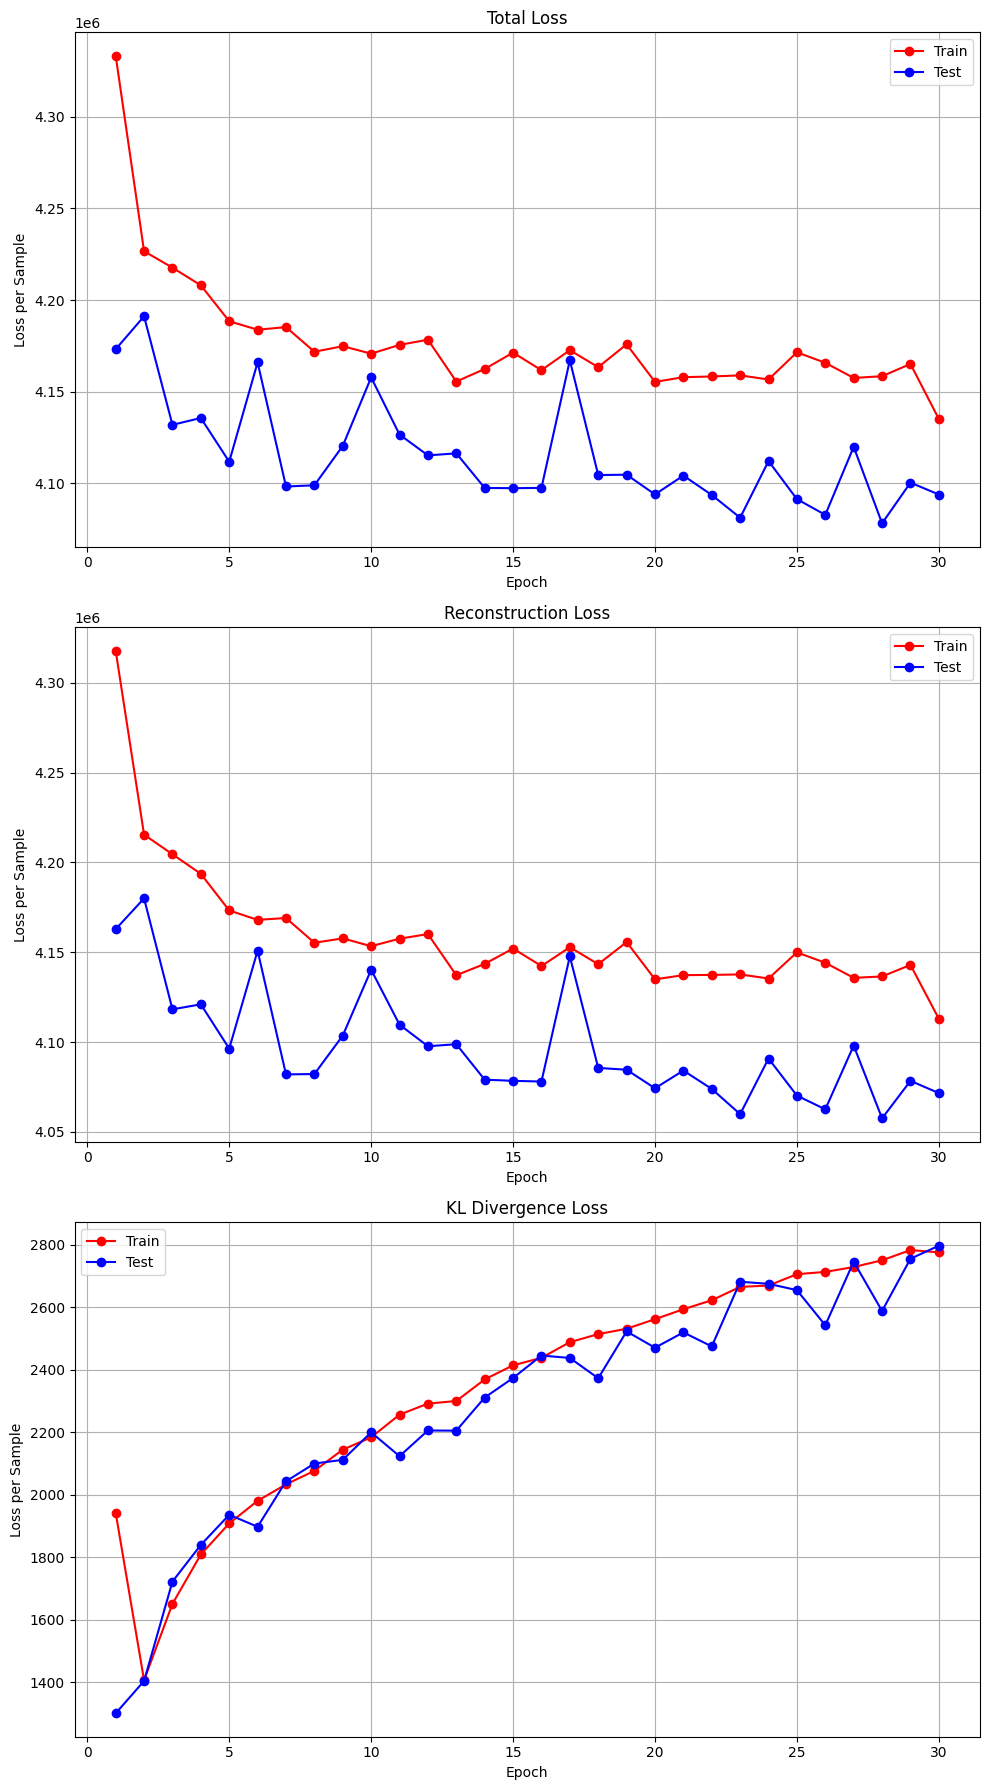

In [ ]:
# Call the plot function after training is complete
plot_losses(train_reconstruction_losses, train_KL_losses, train_tot_losses, eval_reconstruction_losses, eval_KL_losses, eval_tot_losses, exp_kwargs["num_epochs"])


Extracting latent space for training data...
Extracting latent space for validation data...
Plotting training latent space (PCA) with gradient color...
Directly applying PCA for 2D latent space...
Reducing latent space to 2D using PCA...


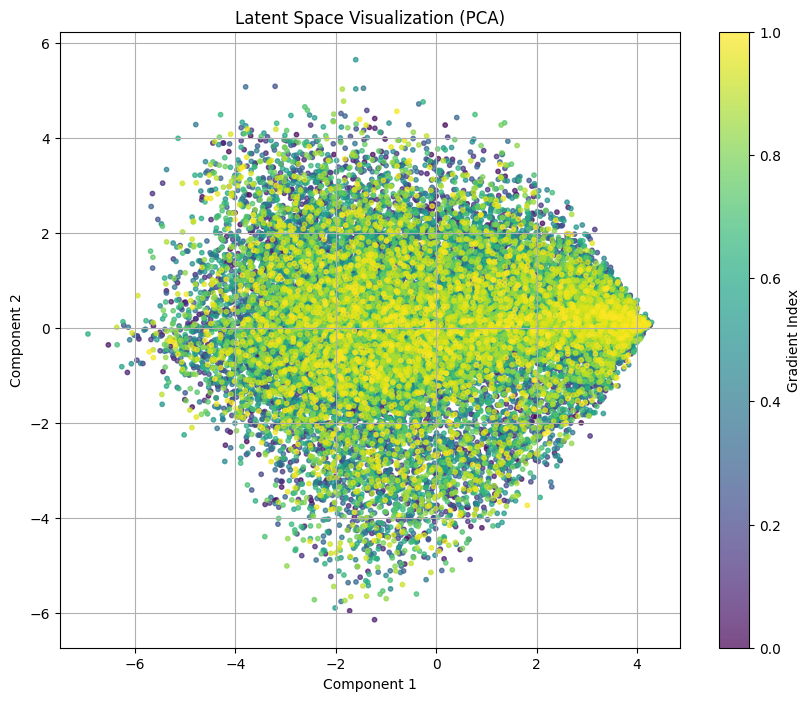

Plotting validation latent space (PCA) with gradient color...
Directly applying PCA for 2D latent space...
Reducing latent space to 2D using PCA...


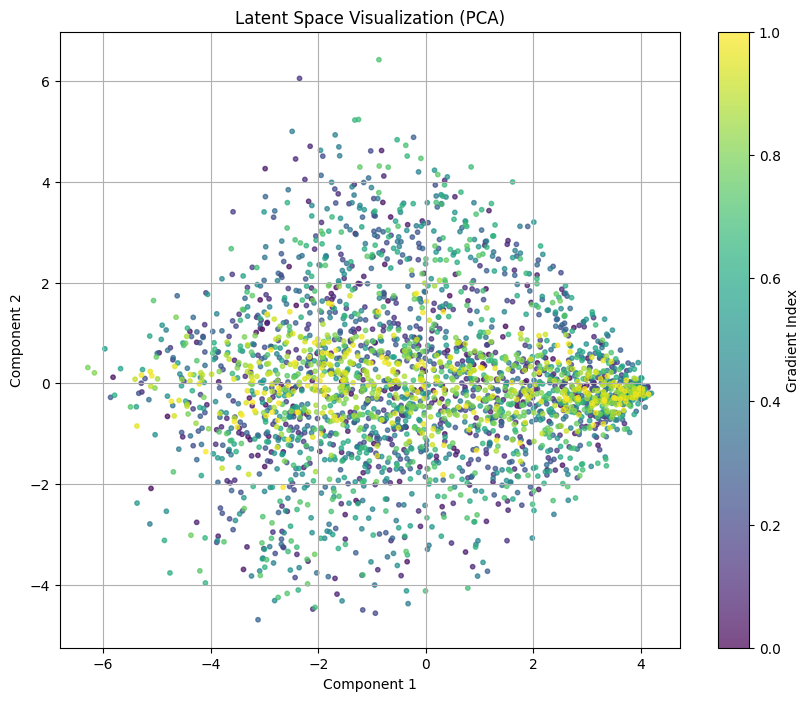

Plotting training latent space (t-SNE) with gradient color...
Reducing latent space to 50 dimensions using PCA...
Reducing latent space to 2D using TSNE...


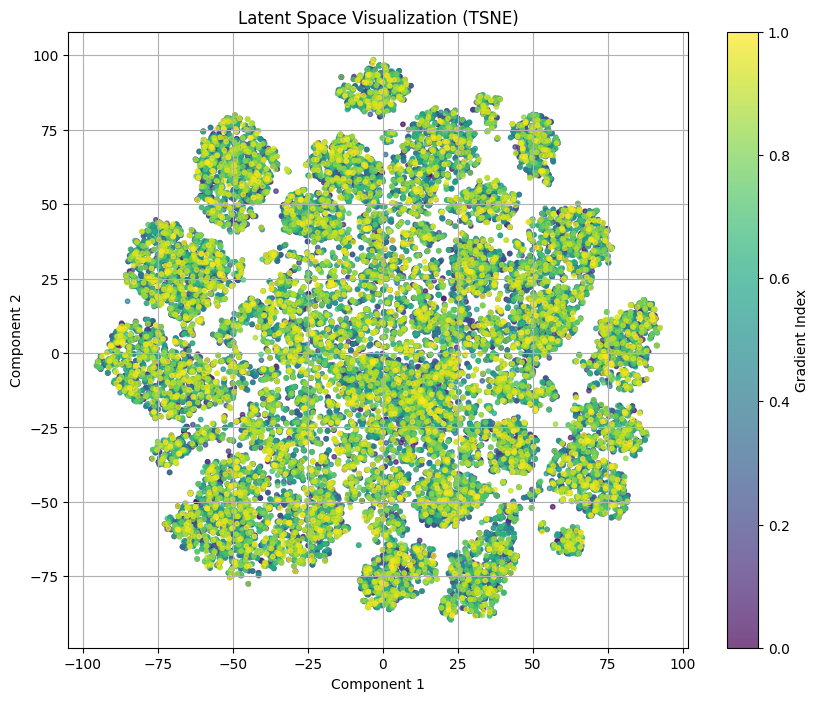

Plotting validation latent space (t-SNE) with gradient color...
Reducing latent space to 50 dimensions using PCA...
Reducing latent space to 2D using TSNE...


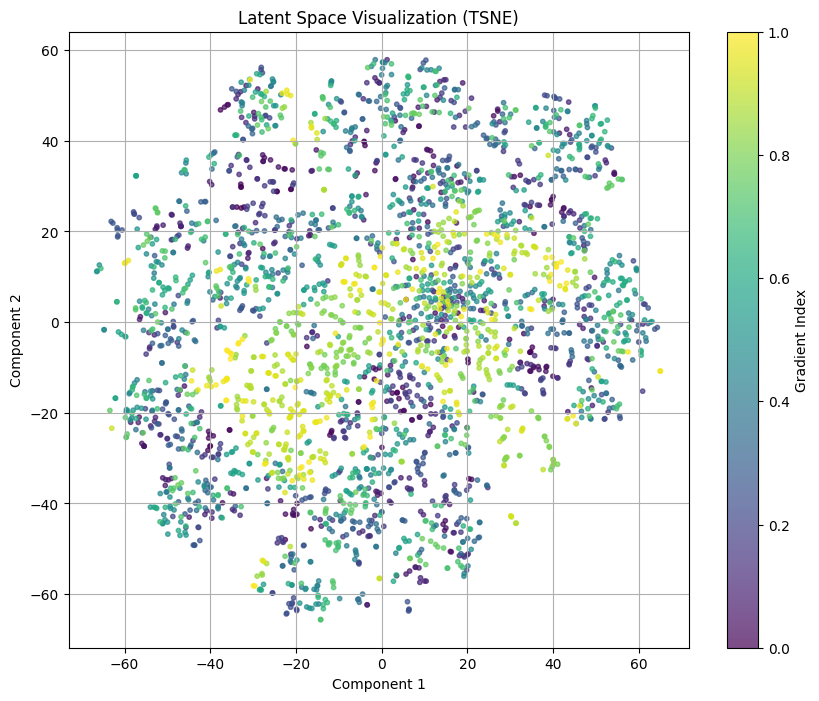

In [ ]:
# Function to extract latent space
@torch.no_grad()
def extract_latent_space(model, dataloader, device='cuda'):
    model.eval()
    all_mu = []

    for batch in dataloader:

        front_images = batch.input['front_images'].to(device)
        mount_images = batch.input['mount_images'].to(device)

        # Getting latent mu by passing through encoder
        mu, _ = model.encode(front_images, mount_images)
        all_mu.append(mu.cpu())

    return torch.cat(all_mu, dim=0).numpy()

def plot_latent_space(latent_vectors, method='pca', gradient_color=True):

    # Step 1: Reduce to 50D using PCA for efficient t-SNE
    if method == 'tsne':
        print("Reducing latent space to 50 dimensions using PCA...")
        pca = PCA(n_components=50)
        reduced_data = pca.fit_transform(latent_vectors)
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        print("Directly applying PCA for 2D latent space...")
        reducer = PCA(n_components=2)
        reduced_data = latent_vectors
    else:
        raise ValueError("Unsupported method. Use 'pca' or 'tsne'.")

    # Step 2: Reduce to 2D
    print(f"Reducing latent space to 2D using {method.upper()}...")
    reduced = reducer.fit_transform(reduced_data)
    plt.figure(figsize=(10, 8))
    if gradient_color:
        colors = np.linspace(0, 1, reduced.shape[0])
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, cmap='viridis', s=10, alpha=0.7)
        plt.colorbar(scatter, label="Gradient Index")
    else:

        plt.scatter(reduced[:, 0], reduced[:, 1], s=10, alpha=0.7)

    # Adding labels and grid
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Extract latent space representations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Extracting latent space for training data...")
train_latent = extract_latent_space(vae_model, train_dataloader_1, device=device)

print("Extracting latent space for validation data...")
val_latent = extract_latent_space(vae_model, val_dataloader_1, device=device)

# Plotting latent space (PCA) with gradient color
print("Plotting training latent space (PCA) with gradient color...")
plot_latent_space(train_latent, method='pca', gradient_color=True)

print("Plotting validation latent space (PCA) with gradient color...")
plot_latent_space(val_latent, method='pca', gradient_color=True)

# Plotting latent space with t-SNE
print("Plotting training latent space (t-SNE) with gradient color...")
plot_latent_space(train_latent, method='tsne', gradient_color=True)

print("Plotting validation latent space (t-SNE) with gradient color...")
plot_latent_space(val_latent, method='tsne', gradient_color=True)


# ******* INSERT YOUR CODE HERE - END *******#


### Question 2.b Model convergence (12 marks)

### Model Description :

In section 2, I have trained a Variational Autoencoder (VAE) in a self-supervised manner, making it learns from image data alone, without using any action information. The model works with images captured from two cameras - one mounted on the robot's front and another on the robot's arm. These images are transformed into a latent space, a compressed representation of the key features of the images, using two separate encoders—one for each camera.

I have used the two different types of images as the VAE is supposed to extract meaningful features from the data, and combining these images enables the model to learn a more comprehensive representation of the environment. The front camera captures a global perspective of the scene, while the mounted camera provides a more localized view of the robot's immediate surroundings. By mixing these distinct features, the model is encouraged to learn a latent space that effectively represents both broader and more specific aspects of the environment. This approach allows the VAE to capture richer and more robust latent features, which can help improve its ability to generalize to diverse situations in the real world. The model learns to recreate the original images from this compressed latent space using a decoder. During training, the model is guided by two types of losses, the reconstruction loss, which measures how accurately the images are recreated, and the KL divergence, which helps ensure the latent space is well-structured. A parameter called beta is used to control the balance between these two losses. The training process uses batches of images and calculates the loss for both the training and validation datasets. It updates the model's parameters through backpropagation to minimize the total loss. The code also includes plotting functions to visualize how the reconstruction loss, KL divergence, and total loss change during training, helping to assess how well the model is learning.


##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;


The training and validation losses across epochs provide strong empirical evidence of the model's training progress, demonstrating both improvements and some challenges. In the early stages of training, both the training and validation losses decrease significantly, indicating that the model is learning and refining its ability to reconstruct input data. For example, at Epoch 1, the training loss is 4,333,351.7150 and the validation loss is 4,173,211.7998. By Epoch 30, the training loss reduces to 4,135,153.8275, and the validation loss drops to 4,093,946.3643. This steady reduction in both losses suggests that the model is gradually improving in learning meaningful representations of the data and becoming better at reconstruction, reflecting appropriate training progress.

Moreover, the reconstruction loss, a key component of the total loss, follows a similar decreasing trend. The reconstruction validation loss starts at 4,162,805.1164 at Epoch 1 and decreases to 4,071,572.4515 by Epoch 30. This reduction signifies that the model is successfully capturing the essential features of the data over time. However, the behavior of the KL divergence loss provides additional insights. The training and validation KL divergence steadily increases in a fluctuating manner from  around 1942.4 and 1300.8 at Epoch 1 and then to (both KL training and validation loss) around 2800 at Epoch 30, suggesting that while reconstruction quality is improving, the model is increasingly prioritizing regularization of the latent space. This growing KL divergence could be destabilizing the model's training process, highlighting a potential imbalance between improving reconstruction accuracy and enforcing the latent space's desired distribution.

However, the widening gap between the training and validation losses, especially from Epoch 9 onward, further signals potential overfitting. These observations is also supported by the loss plots for total loss, reconstruction loss, which show that the total and reconstruction losses both are following a downward trend but with a increasing gap between training and validation.

Also, the increasing KL divergence, despite improvements in reconstruction, suggests the model is diverging from the prior distribution which I will mention more about in next question.


- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

Although the steady decrease in total and reconstruction losses as can be seen in the total and reconstruction loss graph indicates progress, the model has not fully converged. The increasing KL divergence as can be seen in the KL Divergence Graph and the growing gap between training and validation losses, that can be interpreted from the total and reconstruction loss graphs, signals that the model might be overfitting. From Epoch 9 onward, the gap between the training and validation losses starts to widen significantly. While the training loss continues to decrease, the validation loss fluctuates and doesn't exhibit the same smooth reduction pattern. For instance, the validation loss fluctuates between 4,093,946.3643 (Epoch 30) and 4,173,211.7998 (Epoch 1), while the training loss shows a more steady reduction, which suggests the model is memorizing the training data rather than generalizing well to the unseen validation data. This widening gap suggests overfitting, where the model learns patterns specific to the training set that do not generalize to new data.

The increasing KL divergence, even as the reconstruction loss improves, signals that the model is increasingly prioritizing regularization over reconstruction quality. While the goal of a VAE is to balance these two objectives, the growing KL divergence—rising from 1942.4(training) and 1300.8(validation) in Epoch 1 to around 2800(both training and validation is around 2800) in Epoch 30—indicates that the model might be putting too much weight on the latent space regularization, which could be detrimental to overall performance, particularly for downstream tasks. The reason behind the increasing KL divergence can be the combination of a latent dimension of 128 and a beta value of 8 in the loss function. The high latent dimension provides more capacity for encoding information, which can cause the latent space to diverge further from the prior distribution if not properly regularized. Additionally, the large beta value amplifies the KL divergence term in the loss, enforcing stricter alignment with the prior but potentially at the expense of reconstruction quality. This combination likely leads to the observed increase in KL divergence.

While the steady reduction in both training and validation losses, along with improvements in reconstruction loss, shows that the model is learning effectively, the increasing KL divergence and the widening gap between training and validation losses suggest that the model has not fully converged. To address this, adjustments such as lowering the learning rate, tuning the beta value to balance the reconstruction and KL divergence terms, and applying regularization techniques could improve convergence and generalization.



### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__.

For this section, I will be referring to the pca and tsne plots for the latent space analysis plotted earlier :

PCA Analysis (Training and Validation):

The PCA analysis of the training data reveals a denser distribution of points in the 2D latent space. This indicates that the VAE is effectively capturing a broader range of variations in the visual features from both the 'front_cam_ob' and 'mount_cam_ob' images, and there is a higher concentration of similar data points in the latent space. However, despite this denser distribution, there are no distinct clusters, which suggests that the VAE has not fully differentiated between fundamentally different robot arm movements. This could be due to the inherent complexity of the task or limitations in the model architecture. In contrast, the PCA plot for the validation data shows a much more dispersed distribution, with points spread out in the latent space. This suggests that while the VAE has generalized to some extent, it struggles to capture the underlying structure of the validation data as effectively as it did with the training data. The gradient color transitions in both plots indicate that the VAE is learning a continuous latent space, which is essential for generating smooth transitions in robot arm movements.

TSNE Analysis (Training and Validation):

The t-SNE plots provide a more detailed view of the latent space and highlight the differences between the training and validation data. In the training data, the t-SNE plot reveals distinct clusters and substructures which are overlapping as well, indicating that the VAE has learned patterns in the mount and front camera images. These clusters suggest that the model has been able to capture intrinsic features based on images, which is valuable for generating realistic robot arm motions. The smooth gradient color transition across these clusters indicates that the VAE is learning a continuous latent space. However, in the validation data, the t-SNE plot shows a more dispersed latent space with less distinct and more overlapping points. This suggests that the VAE might be overfitting to the training data and is not generalizing well to unseen data. While the model still captures some meaningful patterns, the lack of clear differentiation between movements suggests room for improvement.



Therefore, the latent space analysis using PCA and t-SNE plots provides valuable insights into the effectiveness of the self-supervised VAE method for downstream tasks. The PCA analysis shows that while the VAE captures a wide range of variations in the training data, the lack of distinct clusters suggests that the model has not fully differentiated between different robot arm movements. The validation data shows more dispersion, indicating challenges in generalizing. The t-SNE analysis further highlights these differences, with the training data showing some cluster formation while the validation data exhibits overlapping points, suggesting overfitting. Although the VAE captures meaningful patterns in the training set, its ability to generalize to unseen data is limited. This indicates that while the VAE's representation may help in learning robot arm behaviors, further improvements are needed to ensure it will be fully beneficial for the downstream supervised task.




### Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [ ]:
# ******* INSERT YOUR CODE HERE *******

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from typing import List


# Define Supervised Head
class SupervisedHead(nn.Module):
    def __init__(self, latent_dim, additional_input_dim, pos_output_dim, grp_output_dim):
        super(SupervisedHead, self).__init__()

        # Define fully connected layers
        self.fc1 = nn.Linear(143, 256)
        self.fc2 = nn.Linear(256, 128)

        # Separate layers for pos and grp predictions
        self.fc_pos = nn.Linear(128, pos_output_dim)  # Positional actions
        self.fc_grp = nn.Linear(128, grp_output_dim)  # Gripper actions

    def forward(self, latent, additional_inputs):

        # Concatenating the latent vector with the additional inputs
        x = torch.cat([latent, additional_inputs], dim=-1)

        # Passing through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Separating outputs for position and gripper
        pos_output = self.fc_pos(x)
        grp_output = self.fc_grp(x)
        return pos_output, grp_output


# Supervised head with pretrained VAE
class VAEWithSupervisedHead(nn.Module):
    def __init__(self, vae_model, latent_dim, additional_input_dim, pos_output_dim, grp_output_dim):
        super(VAEWithSupervisedHead, self).__init__()
        # Pretrained VAE
        self.vae_model = vae_model
        self.supervised_head = SupervisedHead(latent_dim, additional_input_dim, pos_output_dim, grp_output_dim)

    def forward(self, front_images, mount_images, additional_inputs):
        # Extracting latent representations from the VAE model
        mu, _ = self.vae_model.encode(front_images, mount_images)
        # Passing through the supervised head
        pos_output, grp_output = self.supervised_head(mu, additional_inputs)
        return pos_output, grp_output



vae_model.eval()
latent_dim = 50
additional_input_dim = 8
pos_output_dim = 3
grp_output_dim = 3

supervised_model = VAEWithSupervisedHead(vae_model, latent_dim, additional_input_dim, pos_output_dim, grp_output_dim).to(device)

# FreezING the parameters of the VAE model (feature extraction part)
for param in vae_model.parameters():
    param.requires_grad = False


optimizer = optim.Adam(supervised_model.supervised_head.parameters(), lr=0.001)

# Loss functions for pos and grp predictions
criterion_pos = nn.MSELoss()
criterion_grp = nn.CrossEntropyLoss()

# Training loop
def train_supervised_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=20, device='cuda'):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(train_dataloader):

            input_data = batch["input"]
            additional_inputs = input_data["obs"].to(device)
            front_images = input_data["front_images"].to(device)
            mount_images = input_data["mount_images"].to(device)
            target_pos = batch["output"]["pos"].to(device)
            target_grp = batch["output"]["grp"].to(device)

            # Forward pass through the full model
            pred_pos, pred_grp = model(front_images, mount_images, additional_inputs)
            # Computing the losses for both outputs
            loss_pos = criterion_pos(pred_pos, target_pos)
            loss_grp = criterion_grp(pred_grp, target_grp.argmax(dim=1))

            # Total loss
            loss = loss_pos + loss_grp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average training loss
        train_losses.append(epoch_loss / len(train_dataloader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_dataloader):.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                input_data = batch["input"]
                additional_inputs = input_data["obs"].to(device)
                front_images = input_data["front_images"].to(device)
                mount_images = input_data["mount_images"].to(device)
                target_pos = batch["output"]["pos"].to(device)
                target_grp = batch["output"]["grp"].to(device)

                pred_pos, pred_grp = model(front_images, mount_images, additional_inputs)

                # Validation losses
                val_loss_pos = criterion_pos(pred_pos, target_pos)
                val_loss_grp = criterion_grp(pred_grp, target_grp.argmax(dim=1))

                val_loss += (val_loss_pos + val_loss_grp).item()

        # Average validtion loss
        val_losses.append(val_loss / len(val_dataloader))
        print(f"Validation Loss: {val_loss / len(val_dataloader):.4f}")
        model.train()


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', marker='o')
    plt.title('Training and Validation Losses per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# ******* INSERT YOUR CODE HERE - END *******#



Epoch [1/20], Loss: 1.4000
Validation Loss: 0.8328
Epoch [2/20], Loss: 0.7408
Validation Loss: 0.7760
Epoch [3/20], Loss: 0.7060
Validation Loss: 0.7794
Epoch [4/20], Loss: 0.6774
Validation Loss: 0.8204
Epoch [5/20], Loss: 0.6540
Validation Loss: 0.8094
Epoch [6/20], Loss: 0.6466
Validation Loss: 0.8299
Epoch [7/20], Loss: 0.6262
Validation Loss: 0.8492
Epoch [8/20], Loss: 0.6187
Validation Loss: 0.7817
Epoch [9/20], Loss: 0.6091
Validation Loss: 0.8048
Epoch [10/20], Loss: 0.5932
Validation Loss: 0.8629
Epoch [11/20], Loss: 0.5877
Validation Loss: 0.8303
Epoch [12/20], Loss: 0.5792
Validation Loss: 0.8798
Epoch [13/20], Loss: 0.5663
Validation Loss: 0.8409
Epoch [14/20], Loss: 0.5515
Validation Loss: 0.9361
Epoch [15/20], Loss: 0.5397
Validation Loss: 1.0252
Epoch [16/20], Loss: 0.5288
Validation Loss: 1.0243
Epoch [17/20], Loss: 0.5162
Validation Loss: 0.9562
Epoch [18/20], Loss: 0.4979
Validation Loss: 1.0096
Epoch [19/20], Loss: 0.4852
Validation Loss: 1.0792
Epoch [20/20], Loss: 

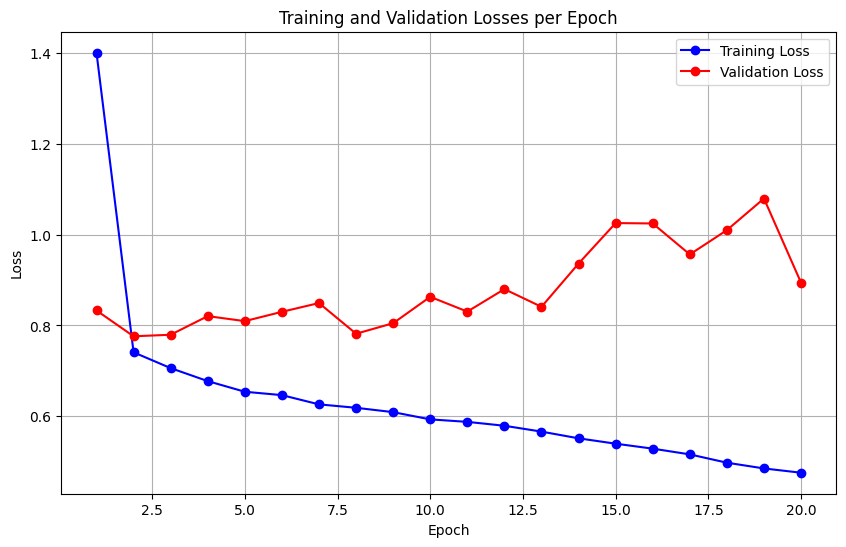

In [ ]:
# Creating Dataset
import torch
from torch.utils.data import Dataset, DataLoader

#Creating new dataset as the previous one was throwing error and the features datatype were not compatible

class RoboticDataset(Dataset):
    def __init__(self, data_dict):
        """
        Args:
            data_dict (dict): Dictionary with keys and values loaded from .h5 files.
        """
        self.actions = data_dict["actions"]
        self.front_cam_ob = data_dict["front_cam_ob"]
        self.mount_cam_ob = data_dict["mount_cam_ob"]
        self.terminals = data_dict["terminals"]
        self.ee_cartesian_pos_ob = data_dict["ee_cartesian_pos_ob"]
        self.ee_cartesian_vel_ob = data_dict["ee_cartesian_vel_ob"]
        self.joint_pos_ob = data_dict["joint_pos_ob"]
        self.num_samples = len(self.actions)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Returns a single sample as a dictionary.
        """
        return {
            "actions": self.actions[idx],
            "front_cam_ob": self.front_cam_ob[idx],
            "mount_cam_ob": self.mount_cam_ob[idx],
            "ee_cartesian_pos_ob": self.ee_cartesian_pos_ob[idx],
            "ee_cartesian_vel_ob": self.ee_cartesian_vel_ob[idx],
            "joint_pos_ob": self.joint_pos_ob[idx]
        }


def collate_func_2(batch):
    obs = []
    pos = []
    _grp = []
    front_images = []
    mount_images = []

    for sample in batch:
        obs.append(
            torch.cat([
                torch.tensor(sample["ee_cartesian_pos_ob"], dtype=torch.float32),
                torch.tensor(sample["ee_cartesian_vel_ob"], dtype=torch.float32),
                torch.tensor(sample["joint_pos_ob"], dtype=torch.float32).flatten()
            ], dim=0)
        )
        pos.append(torch.tensor(sample["actions"][:3], dtype=torch.float32))
        _grp.append(torch.tensor(sample["actions"][-1:], dtype=torch.long))
        front_images.append(torch.tensor(sample["front_cam_ob"], dtype=torch.float32).unsqueeze(0))
        mount_images.append(torch.tensor(sample["mount_cam_ob"], dtype=torch.float32).unsqueeze(0))


    obs = torch.stack(obs)
    pos = torch.stack(pos)
    _grp = torch.stack(_grp)
    grp = torch.zeros(_grp.shape[0], 3, dtype=torch.float32)
    grp[torch.arange(len(grp)), _grp.squeeze()] = 1

    front_images = torch.stack(front_images)
    mount_images = torch.stack(mount_images)

    return {
        "input": {
            "obs": obs,
            "front_images": front_images,
            "mount_images": mount_images
        },
        "output": {
            "pos": pos,
            "grp": grp
        }
    }


# Initialize the train and validation datasets
train_dataset = RoboticDataset(train_nps)
val_dataset = RoboticDataset(val_nps)

# Initialize the dataloaders
batch_size = 50
train_dataloader_2 = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_func_2
)

val_dataloader_2 = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_func_2
)

# Training the model
train_supervised_model(supervised_model, train_dataloader_2, val_dataloader_2, optimizer, num_epochs=20, device=device)


### Question 3.b Assessing the suitability of self-supervised learning
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks)

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# Load the test dataset
test_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


In [ ]:
print(test_nps.keys())

dict_keys(['actions', 'front_cam_ob', 'mount_cam_ob', 'terminals', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'joint_pos_ob'])


In [ ]:
exp_kwargs = {
    "batch_size": 100,
    "learning_rate": 0.0001,
    "half_precision": True,
    "target_offset": 0
}

if exp_kwargs["half_precision"]:
    test_dataset = NpDictDataset(
        array_dict=test_nps,
        transform_lkp=global_transforms,
        dep_vars=["actions"],
        indep_vars=[
            "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
        ],
        target_offset=exp_kwargs["target_offset"]
    )
else:
    test_dataset = NpDictDataset(
        array_dict={k: test_nps[k].astype(np.float32) for k in test_nps},
        transform_lkp=global_transforms,
        dep_vars=["actions"],
        indep_vars=[
            "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
        ],
        target_offset=exp_kwargs["target_offset"]
    )

"""print(len(test_nps))
print(test_nps["actions"][0])
out = test_nps["front_cam_ob"][0] """

test_dataloader = DataLoader(
    test_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)


torch.manual_seed(1)
model_1.eval()

if exp_kwargs["half_precision"]:
    if torch.cuda.is_available():
        model_1 = model_1.half().cuda()
    else:
        model_1 = model_1.half()
else:
    if torch.cuda.is_available():
        model_1 = model_1.cuda()

# Define criterion
__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos": pos_criterion,
        "grp": grp_criterion
    }
)

# Initialize accumulators for loss values
total_loss = 0
total_pos_loss = 0
total_grp_loss = 0
num_batches = 0

# Test the model
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        images = batch.input["images"]
        obs = batch.input["obs"]
        targets = batch.output

        # Move data to device and cast to half precision if necessary
        if torch.cuda.is_available():
            images, obs = images.cuda(), obs.cuda()
            targets["pos"] = targets["pos"].cuda()
            targets["grp"] = targets["grp"].cuda()
            if exp_kwargs["half_precision"]:
                images, obs = images.half(), obs.half()
                targets["pos"] = targets["pos"].half()
                targets["grp"] = targets["grp"].half()

        # Forward pass
        outputs = model_1(images, obs)

        # Calculating loss
        try:
            loss = __criterion(outputs, targets)
            pos_loss = pos_criterion(outputs["pos"], targets["pos"])
            grp_loss = grp_criterion(outputs["grp"], targets["grp"])

            # Accumulating losses
            total_loss += loss.item()
            total_pos_loss += pos_loss.item()
            total_grp_loss += grp_loss.item()
            num_batches += 1

        except Exception as e:
            print(f"Error in loss calculation: {e}")
            print(f"Outputs: {outputs}")
            print(f"Targets: {targets}")
            break

# Compute final average losses
final_loss = total_loss / num_batches
final_pos_loss = total_pos_loss / num_batches
final_grp_loss = total_grp_loss / num_batches

print("\n--- Final Test Results For Fully Trained Supervised Model ---\n")
print(f"Final Test Loss: {final_loss}")
print(f"Final Test pos_loss: {final_pos_loss}")
print(f"Final Test grp_loss: {final_grp_loss}")



--- Final Test Results For Fully Trained Supervised Model ---

Final Test Loss: 0.4596670113357843
Final Test pos_loss: 0.00219728245454676
Final Test grp_loss: 0.45747261795343136


In [ ]:
# Testing Supervised Head

def test_supervised_model(model, test_dataloader, device='cuda'):
    model.eval()
    test_loss = 0

    # Initializing the loss functions
    criterion_pos = nn.MSELoss()
    criterion_grp = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):

            input_data = batch["input"]
            additional_inputs = input_data["obs"].to(device)
            front_images = input_data["front_images"].to(device)
            mount_images = input_data["mount_images"].to(device)
            target_pos = batch["output"]["pos"].to(device)
            target_grp = batch["output"]["grp"].to(device)
            pred_pos, pred_grp = model(front_images, mount_images, additional_inputs)
            loss_pos = criterion_pos(pred_pos, target_pos)
            loss_grp = criterion_grp(pred_grp, target_grp.argmax(dim=1))
            loss = loss_pos + loss_grp
            test_loss += loss.item()

        # Print final test loss
        print("\n--- Final Test Results For Supervised Head (combining VAE) Model---\n")
        print(f"Final Test Loss: {test_loss / len(test_dataloader):.4f}")
        print(f"Final Test pos_loss: {(loss_pos):.4f}")
        print(f"Final Test grp_loss: {(loss_grp):.4f}")




# Initializing the test dataset and dataloader
test_dataset = RoboticDataset(test_nps)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func_2
)

# Testing
test_supervised_model(supervised_model, test_dataloader, device=device)






--- Final Test Results For Supervised Head (combining VAE) Model---

Final Test Loss: 0.4735
Final Test pos_loss: 0.0107
Final Test grp_loss: 0.6090


#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.


# Answer -

From the training and validation graph of the supervised head model in section 3.a, it can be inferred that the validation loass was showing an increasing pattern but finally decreaing at the last epoch, and the training loss declined sharply. The huge gap between the training and validation curve showed signs of overfitting and its impact can also be seen when it was tested on test data.

The comparison between the fully supervised model and the supervised head combined with the VAE shows important differences in performance. The fully trained supervised model achieved a final test loss of 0.4597, with a positional loss of 0.0022 and a gripper loss of 0.4575. In contrast, the supervised head, which combined the pretrained VAE model, achieved a final test loss of 0.4735, with a positional loss of 0.0107 and a gripper loss of 0.6090. The fully supervised model outperforms the supervised head across all metrics, particularly for the gripper prediction task, where the fully supervised model's loss (0.4575) is significantly lower than the supervised head's loss (0.6090). This suggests that the self-supervised pretraining with VAE did not improve the model’s ability to predict gripper actions and may have actually hindered performance in this case.

For the positional prediction task, the supervised head model also performed slightly worse than the fully supervised model, with a positional loss of 0.0107 compared to 0.0022. This again indicates that the pretrained latent features from the VAE were not as effective for learning positional actions, potentially due to a mismatch in how the VAE’s latent space was structured for this specific task. As I attempted to combine two different image data sources in the VAE, the model likely required a more complex architecture with better hyperparameter values to efficiently capture the features that could be leveraged effectively by the supervised head. The relatively simple architecture may not have been sufficient for this task, as it might not have been able to adequately model the intricate patterns in the data. Additionally, the supervised head, being a simpler model, may not have had the capacity to fully exploit the features extracted by the VAE, leading to suboptimal performance. A more sophisticated VAE design, combined with a more capable supervised head, would likely have been more beneficial in extracting meaningful features that could enhance the performance of the downstream supervised task. Overall, the final test loss for the fully supervised model (0.4597) remains better than the supervised head model’s loss (0.4735), highlighting that the fully supervised approach yielded better results for this task.

In terms of other considerations, the fully supervised model likely converged faster as can be infered from FIgure .4., data since it was trained end-to-end on the action prediction task, with no reliance on the VAE's latent space. On the other hand, the supervised head model, which incorporated the VAE, may have experienced slower convergence as can be seen from the train and val curve plotted in section 3.a which signifies overfitting, as it required additional adaptation of the VAE’s features for the specific task. While the VAE-based supervised head might reduce the complexity of feature extraction, it leads to a higher parameter count because both the VAE and supervised head are involved. Despite the increased complexity, the fully supervised model performed better overall, indicating that for this task, raw input data (images and robot state) may be more critical than the abstract features learned by the VAE.

From this, we can conclude that the self-supervised pretraining using the VAE was not beneficial for predicting actions in this specific task. The VAE’s latent features did not improve the downstream task, and in some cases, they led to worse results, particularly for the gripper prediction. This suggests that the pretrained features from the VAE were not optimal for the task of predicting robot actions. The fully supervised model, while potentially more complex, directly learned from the input data and outperformed the VAE-based approach.

To make a fairer comparison and reduce bias in the conclusions, several further experiments reuuired to be conducted. Because in this case the VAE model developed in section 2 also showed signs of overfitting which suggested the need for more complex architecture and hyperparameter tuning alongwith the need for balancing both reconstruction and KL divergence loss. So, this might be another reason that the model didn't performed well and maybe with further adjustment it can have the potential to outperform the fully supervised model. For instance, experimenting with different architectures or training objectives for the VAE could yield a latent space that is better suited for action prediction. Additionally, fine-tuning the VAE during the supervised training phase, rather than freezing its parameters, might allow the model to better adapt its features for the task. Another interesting experiment could involve pretraining only the CNN layers of the fully supervised model using self-supervised learning, similar to how the VAE was pretrained, to see if this improves performance on the downstream task.

In summary, while the self-supervised pretraining with VAE showed potential in reducing the need for complex feature extraction, it did not improve performance in predicting actions. Further experiments and empirical evidence are needed to determine whether self-supervised pretraining could be beneficial for similar tasks or if a fully supervised approach is more effective.

